# 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import seaborn as sns
from itertools import combinations

# plt 폰트 설정 
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 데이터 호출

In [332]:
data = pd.read_csv("C:/Users/dlwlg/Desktop/피처엔지니어링한통합데이터/피처엔지니어링일단다한통합데이터.csv")

In [333]:
# 서비스 업종 코드 명 누락 전, 업종다양성 구하기
data['업종다양성'] = data.groupby(['상권_코드_명','기준_년분기_코드'])['서비스_업종_코드_명'].transform('nunique')
    
# 지역별로 groupby
group_cols = ['기준_년분기_코드', '상권_코드_명', '행정동_코드_명', '자치구_코드_명']

# 집객시설 관련 칼럼
columns_to_people = ['집객시설_수', '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수', '유치원_수',
                     '초등학교_수', '중학교_수', '고등학교_수', '대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수',
                     '숙박_시설_수', '공항_수', '철도_역_수', '버스_터미널_수', '지하철_역_수', '버스_정거장_수']

# 연령대별 유동인구 관련 칼럼
age_columns = ['연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수']

# 집계 함수 적용
agg_dict = {
    '유사_업종_점포_수': 'sum',  
    '당월_매출_금액': 'sum',  
    '총_유동인구_수': 'mean',  
    '영역_면적': 'mean',  
    '프랜차이즈_점포_수' : 'sum'
}

# 집객시설 관련 칼럼과 연령대별 유동인구 칼럼에 'mean' 적용
for col in columns_to_people + age_columns:
    agg_dict[col] = 'mean'

# groupby 후 집계
df = data.groupby(group_cols).agg(agg_dict).reset_index()

In [334]:
# 이상치 대체할 칼럼 리스트
target_columns = ["당월_매출_금액", "유사_업종_점포_수"]

# 행정동별 이상치 처리
for dong in df["행정동_코드_명"].unique():
    dong_mask = df["행정동_코드_명"] == dong  # 특정 행정동 선택
    
    for col in target_columns:
        q1 = df.loc[dong_mask, col].quantile(0.2)  # Q1
        q3 = df.loc[dong_mask, col].quantile(0.8)  # Q3
        iqr = q3 - q1  # IQR
        lower_bound = q1 - 1.5 * iqr  # 하한
        upper_bound = q3 + 1.5 * iqr  # 상한

        # 이상치 값 보정
        df.loc[dong_mask, col] = np.clip(df.loc[dong_mask, col], lower_bound, upper_bound)

C:\Users\dlwlg\AppData\Local\Temp\ipykernel_28532\1618472217.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  8.  393.5  35.   12.   40.    8.  393.5  36.   10.   36.    8.  393.5
  36.   10.   37.    9.  393.5  39.   10.   37.    9.  393.5  38.   10.
  36.    9.  393.5  38.   10.   36.    9.  393.5  38.    7.   34.    9.
 393.5  37.    7.   32.    9.  393.5  34.   10.   35.    9.  393.5  35.
   8.   35.    9.  393.5  35.    8.   36.    9.  393.5  36.    8.   39.
  10.  393.5  37.    8.   36.   10.  393.5  36.    8.   34.    9.  393.5
  35.    7.   36.    9.  393.5  35.    7.   34.    8.  393.5  34.    7.
  30.    8.  393.5  31.    6.   26.    8.  393.5  30.    7.   26.    8.
 393.5  28.    7.   26.    7.  393.5  28.    7.   30.    8.  393.5  32.
   7.   30. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[dong_mask, col] = np.clip(df.loc[dong_mask

In [335]:
# 기준년분기코드 기준으로 전분분기 대비 점포수가 증가한 경우에 1/0 부여하기
df = df.sort_values(['상권_코드_명','기준_년분기_코드'])
df['전분기_점포수'] = df.groupby('상권_코드_명')['유사_업종_점포_수'].shift(1) 
df['점포수 증가'] = (df['유사_업종_점포_수'] > df['전분기_점포수']).astype(int)
df['개업 점수'] = df.groupby('상권_코드_명')['점포수 증가'].cumsum()

# 변수들 가공 
group_cols = ['기준_년분기_코드', '상권_코드_명']
df['매출_점포비'] = df['당월_매출_금액'] / df['유사_업종_점포_수']
df['매출_유동인구비'] = df['당월_매출_금액'] / df['총_유동인구_수'] 
df['프랜차이즈_비율'] = df['프랜차이즈_점포_수'] / df['유사_업종_점포_수'] 
df['유동인구_점포비'] = df['총_유동인구_수']  / df['유사_업종_점포_수'] 
df['매출_영역비'] = df['당월_매출_금액'] / df['영역_면적'] 
df['점포수_영역비'] = df['유사_업종_점포_수'] / df['영역_면적'] 
df['소비다수연령대'] = df[age_columns].sum(axis=1)
df['집객시설총합'] = df[columns_to_people].sum(axis=1)

# 경쟁강도 지수 계산
df['경쟁강도'] = df.groupby(group_cols)['유사_업종_점포_수'].transform('sum') / df.groupby(['기준_년분기_코드', '행정동_코드_명'])['유사_업종_점포_수'].transform('sum')

# 포화상태 칼럼 추가
mean_value = df["경쟁강도"].mean()
df['포화상태'] = df['경쟁강도'].apply(lambda x:'포화' if x > mean_value else '여유')

# 중복 제거
df = df.drop_duplicates()

In [336]:
high_competition_count = (df["경쟁강도"] > mean_value).sum()
low_competition_count = (df["경쟁강도"] <= mean_value).sum()
print(f"경쟁강도가 평균보다 큰 행의 개수: {high_competition_count}")
print(f"경쟁강도가 평균보다 작은 행의 개수: {low_competition_count}")

경쟁강도가 평균보다 큰 행의 개수: 11708
경쟁강도가 평균보다 작은 행의 개수: 21302


In [337]:
# data에서 '기준_년분기_코드'와 '상권_코드_명'을 기준으로 '업종다양성'을 평균으로 집계
data_grouped = data.groupby(['기준_년분기_코드', '상권_코드_명'])['업종다양성'].mean().reset_index()

# df와 병합 (df의 30,000개 행을 유지하면서 data_grouped에서 '업종다양성'을 가져옴)
df = pd.merge(df, data_grouped, on=['기준_년분기_코드', '상권_코드_명'], how='left')

# 경쟁강도와 만든 변수 상관관계 재확인

In [317]:
# 분석할 변수 리스트
correlation_features = ['개업 점수','매출_점포비', '매출_유동인구비', '업종다양성', '프랜차이즈_비율', '유동인구_점포비', '매출_영역비','점포수_영역비','소비다수연령대','집객시설총합']

# 스피어만 상관계수 계산 및 정렬
spearman_corr = df[correlation_features + ['경쟁강도']].corr(method='spearman')
spearman_corr_sorted = spearman_corr['경쟁강도'].drop('경쟁강도').sort_values(ascending=False)

# 결과 출력
print(spearman_corr_sorted)


업종다양성       0.680314
집객시설총합      0.636358
점포수_영역비     0.447506
소비다수연령대     0.420809
매출_영역비      0.282671
프랜차이즈_비율    0.250466
매출_유동인구비    0.236642
개업 점수       0.135309
매출_점포비     -0.111648
유동인구_점포비   -0.394616
Name: 경쟁강도, dtype: float64


## 변수추출 자동화

In [352]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import spearmanr  # 스피어만 상관계수

# 사용할 변수 리스트
variables = ['집객시설총합', '업종다양성', '개업 점수', '소비다수연령대', '프랜차이즈_비율', '유동인구_점포비', '점포수_영역비', '매출_유동인구비', '매출_점포비', '매출_영역비']

# 최적 변수 저장
best_score = 0  # 최적 점수 (설명력 * |경쟁강도와 상관계수|)
best_combination = None
best_final_score = None

# 랜덤으로 5~7개 선택한 모든 조합 생성
for r in range(5, 8):
    for subset in combinations(variables, r):
        selected_vars = list(subset)

        df_selected = df[['기준_년분기_코드', '상권_코드_명', '포화상태', '경쟁강도'] + selected_vars]
        df_selected = df_selected.groupby(['기준_년분기_코드', '상권_코드_명', '포화상태', '경쟁강도'])[selected_vars].mean().reset_index()

        if df_selected.empty:
            print(f"Data is empty for combination: {selected_vars}")
            continue

        # 변수 표준화
        scaler = StandardScaler()
        scaled_features = pd.DataFrame(scaler.fit_transform(df_selected[selected_vars]), columns=selected_vars)

        for k in range(1, 3):  # n_components 1~2까지 반복
            pca = PCA(n_components=k)
            principal_components = pca.fit_transform(scaled_features)
            explained_variance = pca.explained_variance_ratio_.sum()  # 설명력

            # 주성분 합산 (1개면 그대로, 2개면 합산)
            pca_score = principal_components[:, 0] if k == 1 else principal_components[:, :k].sum(axis=1)

            # MinMax 스케일링 (0~20)
            pca_score_scaled = MinMaxScaler(feature_range=(0, 20)).fit_transform(pca_score.reshape(-1, 1)).flatten()

            # 경쟁강도와의 상관관계 계산 (스피어만 상관계수 사용)
            correlation, _ = spearmanr(pca_score_scaled, df_selected['경쟁강도'])

            # 최적 점수 = 설명력 * |상관계수|
            score = explained_variance * abs(correlation)

            # 최적 조합 갱신
            if score > best_score:
                best_score = score
                best_combination = selected_vars
                best_final_score = pca_score_scaled

# 결과 출력
if best_combination is not None:
    print(f'최적 변수 조합: {best_combination}')
    print(f'최고 점수 (설명력 * |상관계수|): {best_score}')
    df['포화도 점수'] = best_final_score
else:
    print("유효한 변수 조합을 찾을 수 없습니다.")


최적 변수 조합: ['집객시설총합', '업종다양성', '소비다수연령대', '매출_점포비', '매출_영역비']
최고 점수 (설명력 * |상관계수|): 0.4632193236117885


# 점수 산출

#### 1. PCA 값을 제곱분포로 바꾸고, 0~20 MinMax

In [203]:
# 필요한 컬럼만 선택
features = ['매출_점포비','프랜차이즈_비율','매출_유동인구비','개업 점수','업종다양성']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_selected[features])

In [204]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.9999
각 변수의 설명력 : [[ 9.99999998e-01  2.68606462e-10  5.62101078e-05 -5.00228253e-07
  -1.04131758e-07]]


In [205]:
# 제곱변환
final_scores = np.square(pca_result)

# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
scaled_data = scaler.fit_transform(final_scores)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': scaled_data.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

         상권_코드_명        포화도_점수
26459    신우어린이공원  2.000000e+01
29467    신우어린이공원  1.806777e+01
27963    신우어린이공원  1.762738e+01
32467    신우어린이공원  1.655222e+01
30965    신우어린이공원  1.526191e+01
...          ...           ...
5326    솔밭공원역 1번  1.468455e-10
29932  한양공고앞 교차로  3.929930e-11
22658  구로119안전센터  2.023993e-11
30356        대치역  1.449236e-12
29035     무학봉상점가  0.000000e+00

[33010 rows x 2 columns]


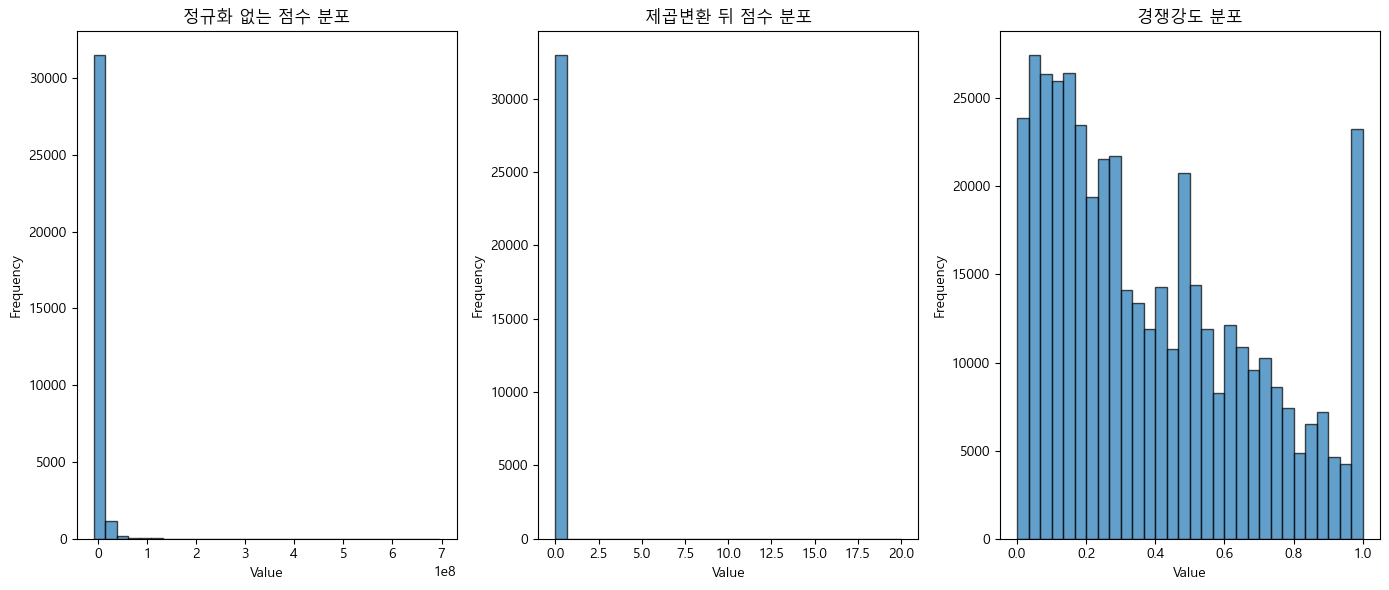

In [206]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  

# 첫 번째 히스토그램: only PCA
axes[0].hist(pca_result, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("정규화 없는 점수 분포")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# 두 번째 히스토그램: 표준화 뒤 0~20
axes[1].hist(result_df['포화도_점수'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("제곱변환 뒤 점수 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[2].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title("경쟁강도 분포")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

#### 2. PCA 값 표준화 뒤 0~20 MinMax하고 정규분포

In [113]:
# 필요한 컬럼만 선택
features = ['개업 점수', '매출_점포비', '매출_유동인구비', '프랜차이즈_비율']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_selected[features])

In [114]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.9999
각 변수의 설명력 : [[-5.00228253e-07  9.99999998e-01  5.62101078e-05  2.68606462e-10]]


In [115]:
# 표준화
ss = StandardScaler()
scaled_data = ss.fit_transform(pca_result)

# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
final_scores = scaler.fit_transform(scaled_data)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': final_scores.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

       상권_코드_명        포화도_점수
26459  신우어린이공원  2.000000e+01
29467  신우어린이공원  1.902096e+01
27963  신우어린이공원  1.879059e+01
32467  신우어린이공원  1.821578e+01
30965  신우어린이공원  1.750070e+01
...        ...           ...
17859    청평화시장  6.879167e-07
16359    청평화시장  4.497233e-07
13359    청평화시장  2.625844e-07
10359    청평화시장  1.929697e-07
19360    청평화시장  0.000000e+00

[33010 rows x 2 columns]


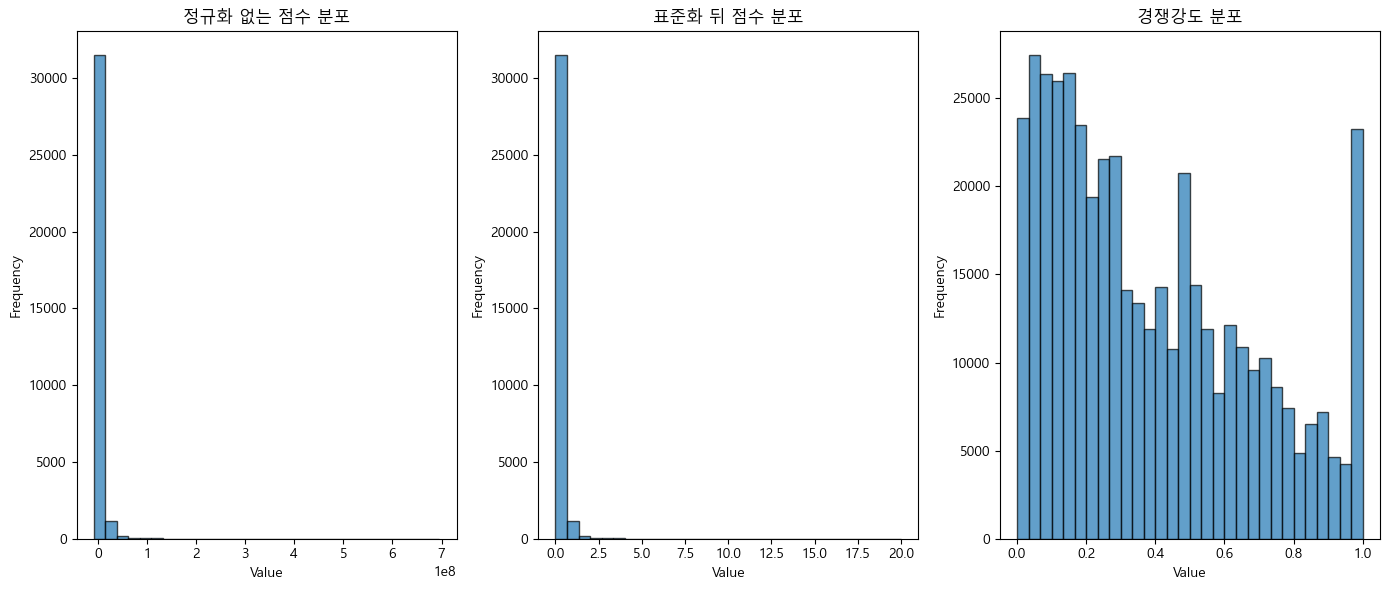

In [116]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  

# 첫 번째 히스토그램: 0~20
axes[0].hist(pca_result, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("정규화 없는 점수 분포")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

# 두 번째 히스토그램: 표준화 뒤 0~20 
axes[1].hist(final_scores, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("표준화 뒤 점수 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[2].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title("경쟁강도 분포")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

#### 3. 변수를 표준화 후 PCA > 0~20 MinMax

In [121]:
# 필요한 컬럼만 선택
features = ['개업 점수', '매출_점포비', '매출_유동인구비', '프랜차이즈_비율']
df_selected = df[['기준_년분기_코드','상권_코드_명'] + features]

# 상권별 평균값 계산
df_selected = df_selected.groupby(['기준_년분기_코드','상권_코드_명'])[features].mean().reset_index()

# 변수 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])
    
# PCA
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_features)

In [122]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.2761
각 변수의 설명력 : [[ 0.71167257 -0.69837227 -0.07036872  0.02909595]]


In [123]:
# 0~20 범위로 변환
scaler = MinMaxScaler(feature_range=(0, 20))
scaled_data = scaler.fit_transform(pca_result)

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': scaled_data.flatten()
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

                      상권_코드_명     포화도_점수
32798              종로·청계 관광특구  20.000000
32015  명동 남대문 북창동 다동 무교동 관광특구  19.923403
31295              종로·청계 관광특구  19.849607
30510  명동 남대문 북창동 다동 무교동 관광특구  19.779858
31799                     노원역  19.756514
...                       ...        ...
30965                 신우어린이공원   2.140411
32467                 신우어린이공원   1.528047
27963                 신우어린이공원   1.035687
29467                 신우어린이공원   0.838571
26459                 신우어린이공원   0.000000

[33010 rows x 2 columns]


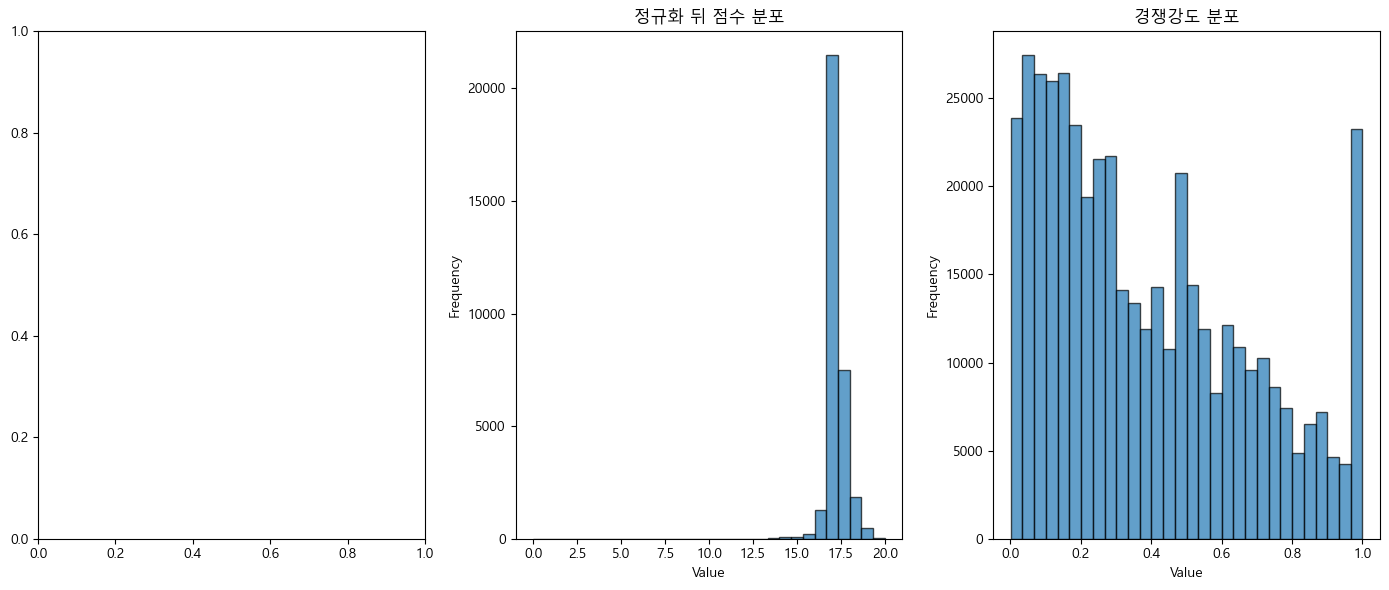

In [124]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  

# # 첫 번째 히스토그램: 0~20
# axes[0].hist(pca_result, bins=30, edgecolor='black', alpha=0.7)
# axes[0].set_title("정규화 없는 점수 분포")
# axes[0].set_xlabel("Value")
# axes[0].set_ylabel("Frequency")

# 두 번째 히스토그램: 0~20 뒤 정규화 
axes[1].hist(scaled_data, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("정규화 뒤 점수 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 세 번째 히스토그램: df['경쟁강도']
axes[2].hist(df['경쟁강도'], bins=30, edgecolor='black', alpha=0.7)
axes[2].set_title("경쟁강도 분포")
axes[2].set_xlabel("Value")
axes[2].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

#### 4. 변수 표준화 > PCA > 0~20 MinMax (채택)

In [410]:
# 필요한 컬럼만 선택
# features = ['매출_점포비','매출_유동인구비','프랜차이즈_비율','개업 점수','업종다양성']
features = ['업종다양성','유동인구_점포비','개업 점수','프랜차이즈_비율','소비다수연령대','집객시설총합','점포수_영역비']
df_selected = df[['기준_년분기_코드','상권_코드_명','포화상태'] + features]

# # 로그 정규화 
# for feature in features:
#      df_selected[features] = np.log1p(df_selected[features])
    
# 변수 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_selected[features])
    
# PCA
n_components = 3
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_features)

In [411]:
# PCA 주성분별 설명 분산 비율 확인
explained_variance = pca.explained_variance_ratio_

# 결과 출력
for i, var in enumerate(explained_variance):
    print(f"주성분 {i+1}: 설명된 분산 비율 = {var:.4f}")
print('각 변수의 설명력 :', pca.components_)

주성분 1: 설명된 분산 비율 = 0.3536
주성분 2: 설명된 분산 비율 = 0.1758
주성분 3: 설명된 분산 비율 = 0.1439
각 변수의 설명력 : [[ 0.58077992 -0.1869126   0.18053613  0.15974779  0.49784746  0.55865133
   0.09850034]
 [-0.06644389  0.62159014 -0.43804792  0.3043908   0.2943961   0.15100577
  -0.46389585]
 [-0.00457242 -0.35711711  0.31975063  0.64365077 -0.23695537 -0.09590654
  -0.53904895]]


In [412]:
# 동적으로 주성분 컬럼명 생성
pc_columns = [f'PC{i+1}' for i in range(n_components)]

# PCA 결과를 DataFrame으로 변환
test_pca_df = pd.DataFrame(pca_result, columns=pc_columns)

# 원래 변수와 주성분 간의 상관관계 계산 (동적으로 처리)
correlation_results = {}
for pc in pc_columns:
    correlation_matrix = pd.DataFrame(scaled_features).corrwith(test_pca_df[pc])
    correlation_results[pc] = correlation_matrix
    print(f"Correlation with {pc}:\n{correlation_matrix}\n")

# 설명된 분산 비율
explained_variance = np.array(pca.explained_variance_ratio_)

# 가중치 계산 (합이 1이 되도록 정규화)
weights = explained_variance / explained_variance.sum()

# 최종 점수 계산 (n_components 개수에 맞게 자동 처리)
test_pca_df['Final_Score'] = test_pca_df[pc_columns].dot(weights)

# 결과 확인
print(test_pca_df)

Correlation with PC1:
0    0.913784
1   -0.294083
2    0.284051
3    0.251343
4    0.783300
5    0.878967
6    0.154978
dtype: float64

Correlation with PC2:
0   -0.073714
1    0.689602
2   -0.485978
3    0.337696
4    0.326608
5    0.167528
6   -0.514654
dtype: float64

Correlation with PC3:
0   -0.004590
1   -0.358475
2    0.320967
3    0.646098
4   -0.237856
5   -0.096271
6   -0.541099
dtype: float64

            PC1       PC2       PC3  Final_Score
0     -0.985885  0.676608  0.180647    -0.302459
1     -0.996749  0.405167  0.081300    -0.400272
2     -1.018024  0.545598  0.134977    -0.363305
3     -0.975390  0.373217  0.183647    -0.375521
4     -0.885303  0.110533  0.205273    -0.392176
...         ...       ...       ...          ...
33005 -0.389491 -0.751475  0.313841    -0.333665
33006 -0.438213 -0.718335  0.360371    -0.340653
33007 -0.406677 -0.905742  0.346193    -0.376054
33008 -0.333471 -1.011533  0.492318    -0.333997
33009 -0.335076 -1.012988  0.493390    -0.334991

[33

In [413]:
# 점수 0 ~ 20 제한
min_max_scaler = MinMaxScaler(feature_range=(0, 20))
Score = min_max_scaler.fit_transform(test_pca_df[['Final_Score']])

# 결과 데이터프레임 생성
result_df = pd.DataFrame({
    '기준_년분기_코드': df_selected['기준_년분기_코드'],
    '상권_코드_명': df_selected['상권_코드_명'],
    '포화도_점수': Score.flatten(),
    '포화상태' : df_selected['포화상태']
})

# 포화도 점수 기준 내림차순 정렬
result_df = result_df.sort_values('포화도_점수', ascending=False)
print(result_df)

       기준_년분기_코드                 상권_코드_명     포화도_점수 포화상태
11100      20194  명동 남대문 북창동 다동 무교동 관광특구  20.000000   포화
11099      20193  명동 남대문 북창동 다동 무교동 관광특구  19.943182   포화
11098      20192  명동 남대문 북창동 다동 무교동 관광특구  19.805792   포화
11097      20191  명동 남대문 북창동 다동 무교동 관광특구  19.750440   포화
11112      20224  명동 남대문 북창동 다동 무교동 관광특구  19.719853   포화
...          ...                     ...        ...  ...
30092      20191                   청평화시장   0.035939   포화
30095      20194                   청평화시장   0.024141   포화
30096      20201                   청평화시장   0.021752   포화
30094      20193                   청평화시장   0.012079   포화
30093      20192                   청평화시장   0.000000   포화

[33010 rows x 4 columns]


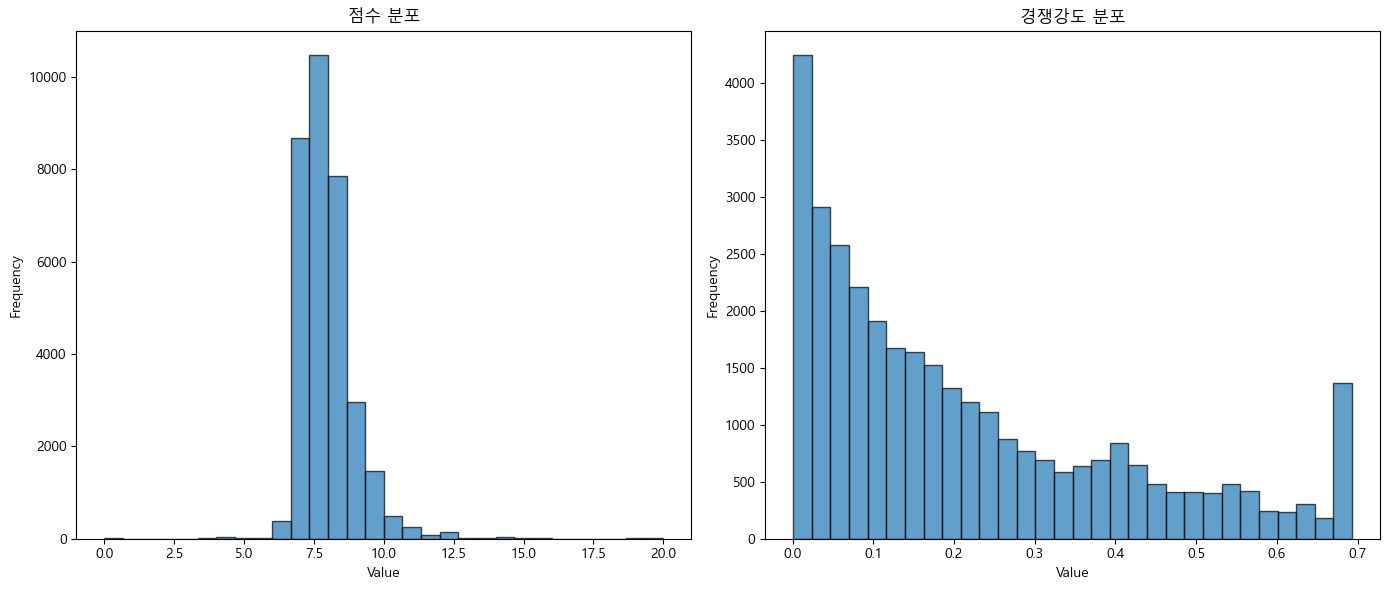

In [414]:
# 피겨 사이즈 설정 및 서브플롯 생성 (가로로 2개 배치)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

# 두 번째 히스토그램: 0~20 뒤 정규화 
axes[0].hist(result_df['포화도_점수'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title("점수 분포")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

test_scaled = np.log1p(df[['경쟁강도']])

# 세 번째 히스토그램: df['경쟁강도']
axes[1].hist(test_scaled, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title("경쟁강도 분포")
axes[1].set_xlabel("Value")
axes[1].set_ylabel("Frequency")

# 그래프 출력
plt.tight_layout()  # 그래프 간 간격 조정
plt.show()

경쟁강도와 포화도_점수의 상관계수: 0.42866353706884114


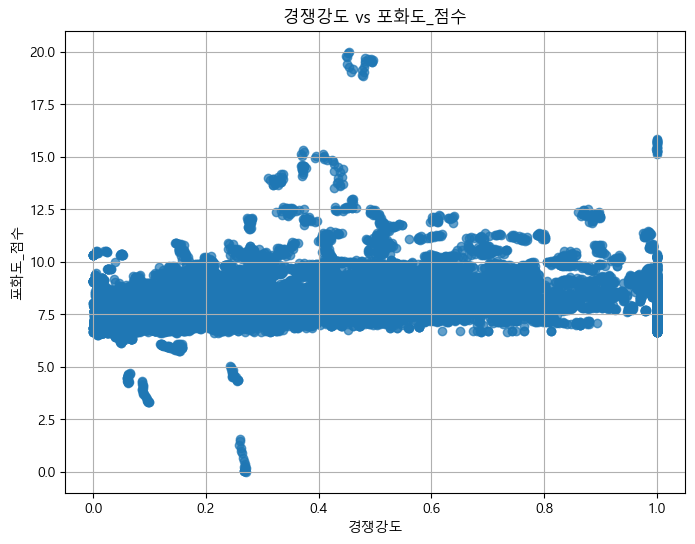

In [415]:
# 두 데이터프레임에서 필요한 열만 선택하여 병합 (inner join)
merged_df = pd.merge(
    df[['기준_년분기_코드', '상권_코드_명', '경쟁강도','행정동_코드_명','자치구_코드_명']],
    result_df[['기준_년분기_코드', '상권_코드_명', '포화도_점수']],
    on=['기준_년분기_코드', '상권_코드_명'],
    how='inner'
)

# 두 변수의 상관계수 계산
correlation = merged_df['경쟁강도'].corr(merged_df['포화도_점수'])
print("경쟁강도와 포화도_점수의 상관계수:", correlation)

# 산점도(scatter plot)로 시각화
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['경쟁강도'], merged_df['포화도_점수'], alpha=0.7)
plt.xlabel('경쟁강도')
plt.ylabel('포화도_점수')
plt.title('경쟁강도 vs 포화도_점수')
plt.grid(True)
plt.show()


Text(0.5, 1.0, '포화상태에 따른 포화도 점수 밀도')

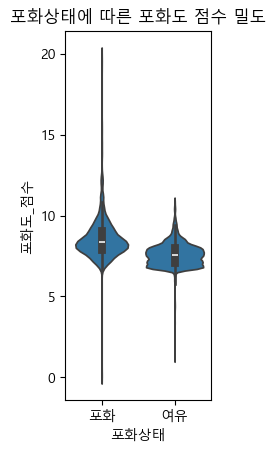

In [416]:
plt.subplot(1, 3, 1)
sns.violinplot(data=result_df, x='포화상태', y='포화도_점수')
plt.title('포화상태에 따른 포화도 점수 밀도')

In [417]:
result_df['여유도 점수'] = round(20 - result_df['포화도_점수'],0)

In [418]:
result_df['여유도 점수'].mean()

np.float64(12.039897000908816)

In [419]:
# features = ['업종다양성','집객시설총합','점포수_영역비','소비다수연령대','유동인구_점포비','매출_유동인구비'] // 주성분 2개
    # result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/최종포화도점수ver2.csv", encoding='cp949') 
    
# features = ['업종다양성','집객시설총합','점포수_영역비','소비다수연령대','유동인구_점포비','개업 점수'] // 주성분 3개 
    #result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/최종포화도점수ver3.csv", encoding='cp949') 

In [420]:
# result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/최종포화도점수ver4.csv", encoding='cp949')  # 이상치제거 뒤 ver2 조건 

In [421]:
# result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/여유도 점수.csv", encoding='cp949')  # 이상치제거 뒤 ver2 조건 

In [422]:
# result_df = result_df[result_df['기준_년분기_코드']==20242]
# result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/여유도 점수 ver2.csv", encoding='cp949')  
# # ['업종다양성','유동인구_점포비','개업 점수','프랜차이즈_비율','소비다수연령대','집객시설총합','점포수_영역비'], comp 3

In [423]:
result_df = result_df[result_df['기준_년분기_코드']==20242]
result_df.to_csv("C:/Users/dlwlg/Desktop/final/상권지수/여유도 점수 ver3.csv", encoding='cp949') 

# 분포 확인

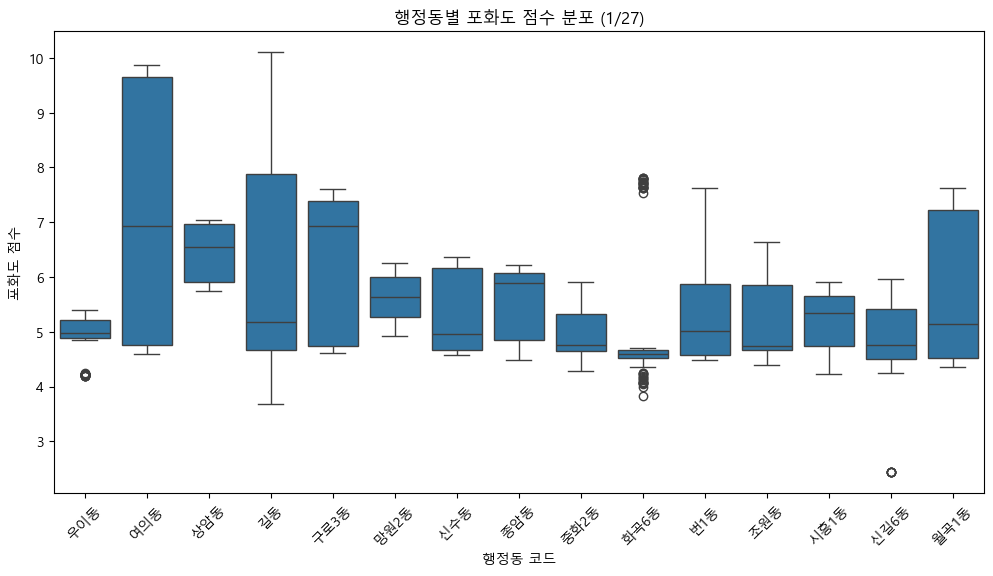

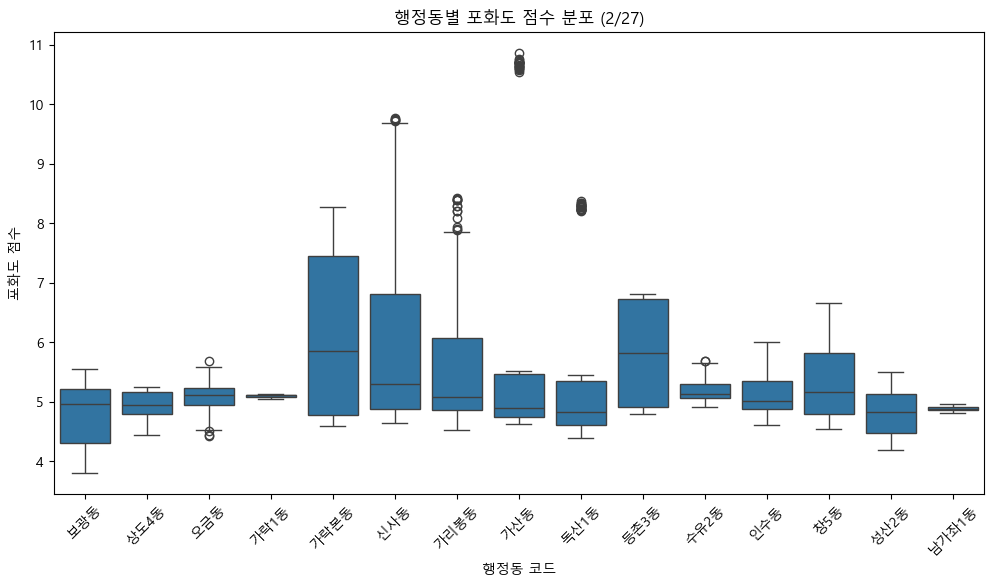

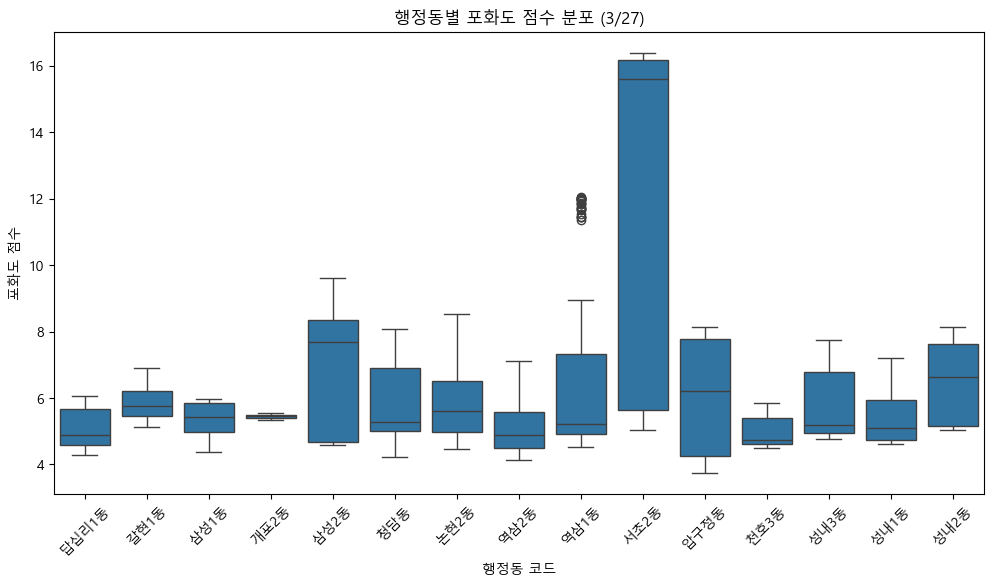

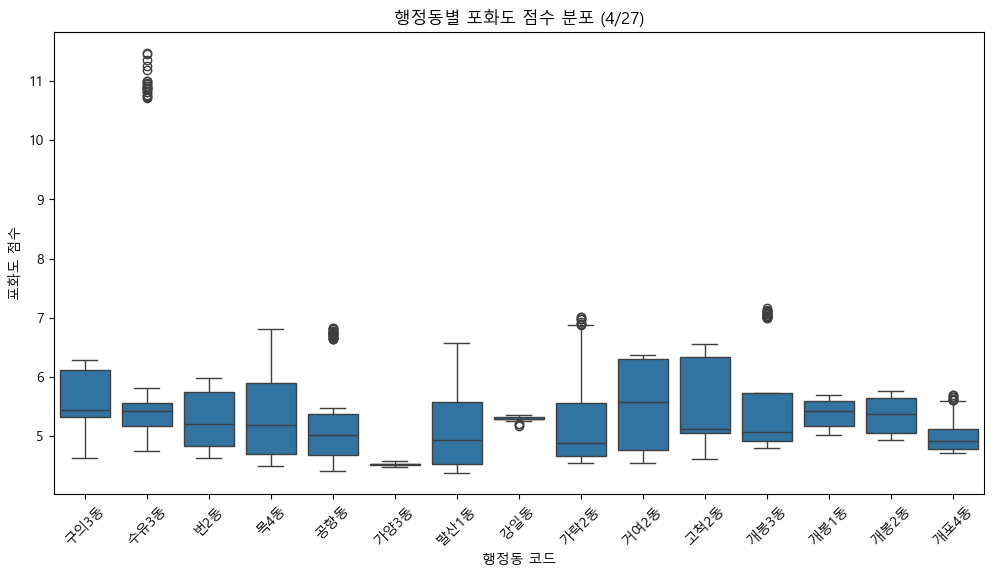

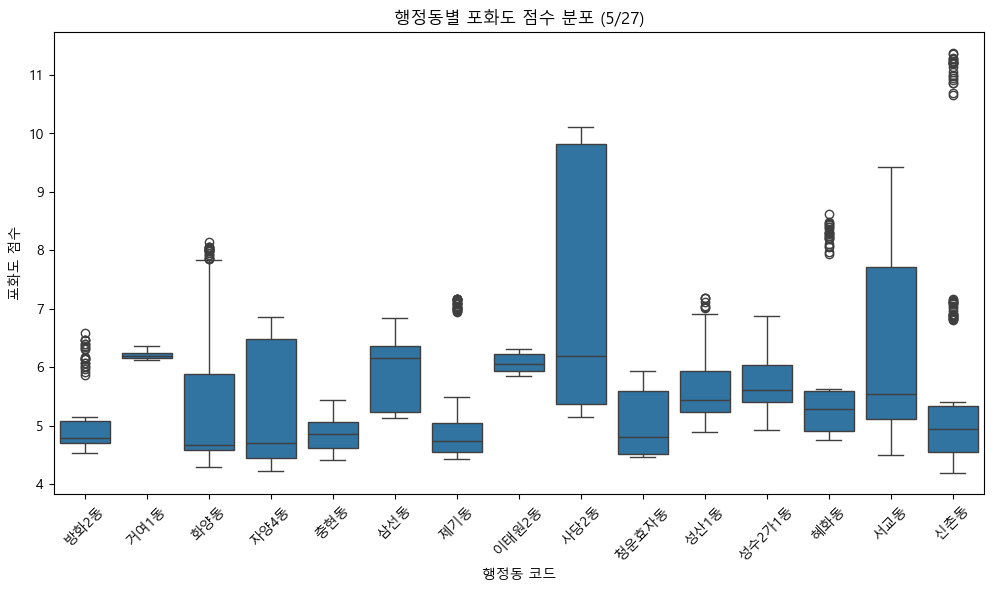

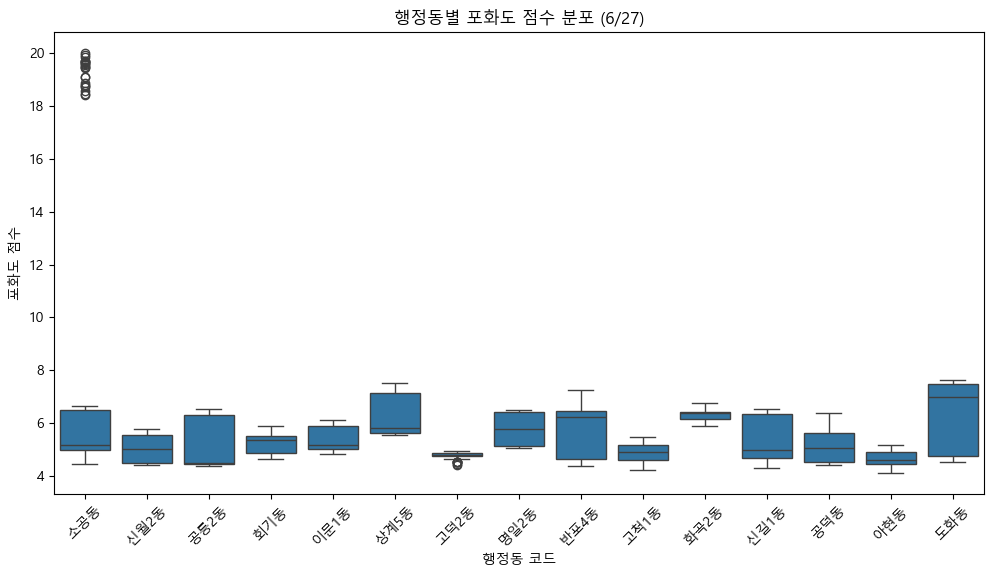

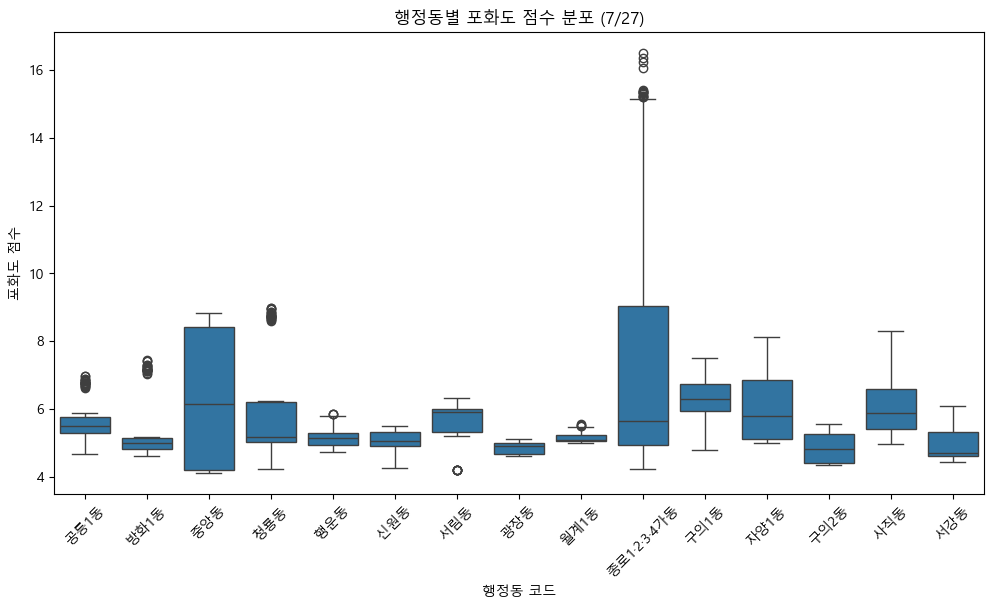

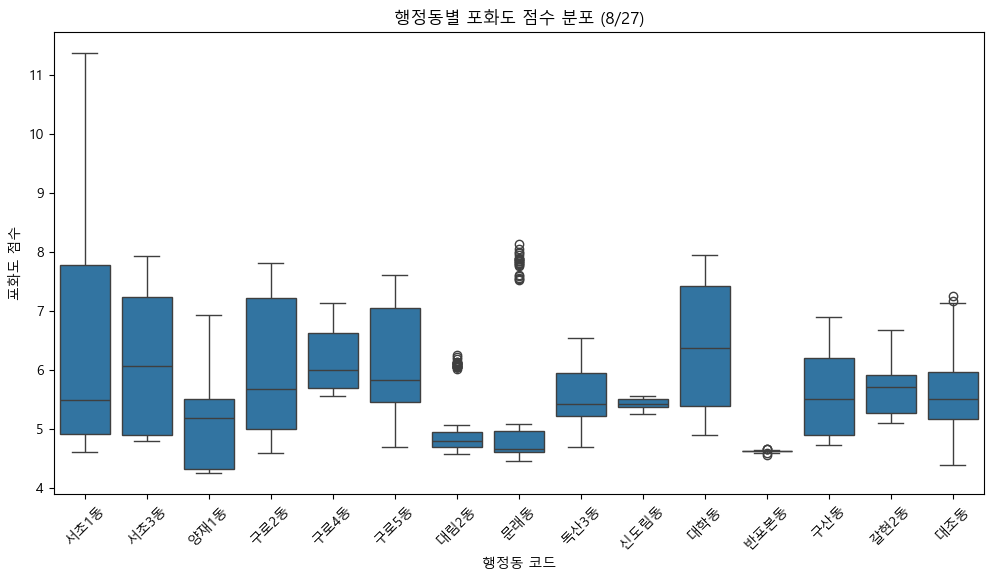

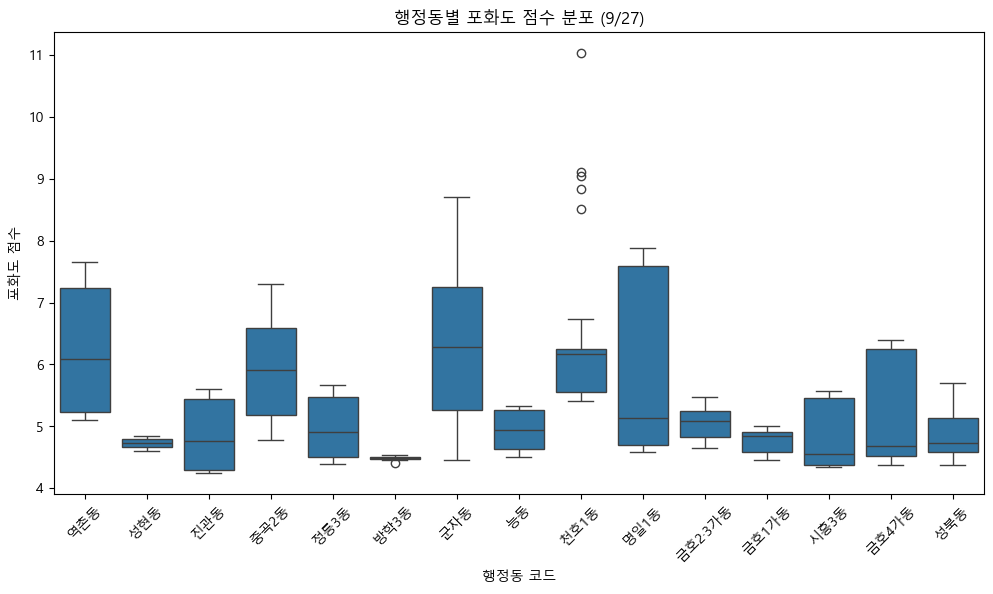

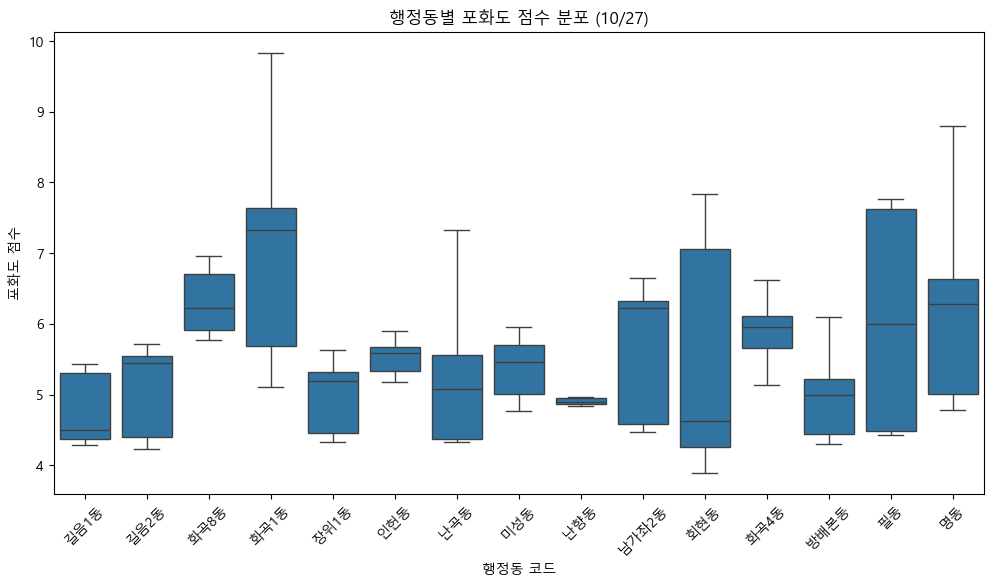

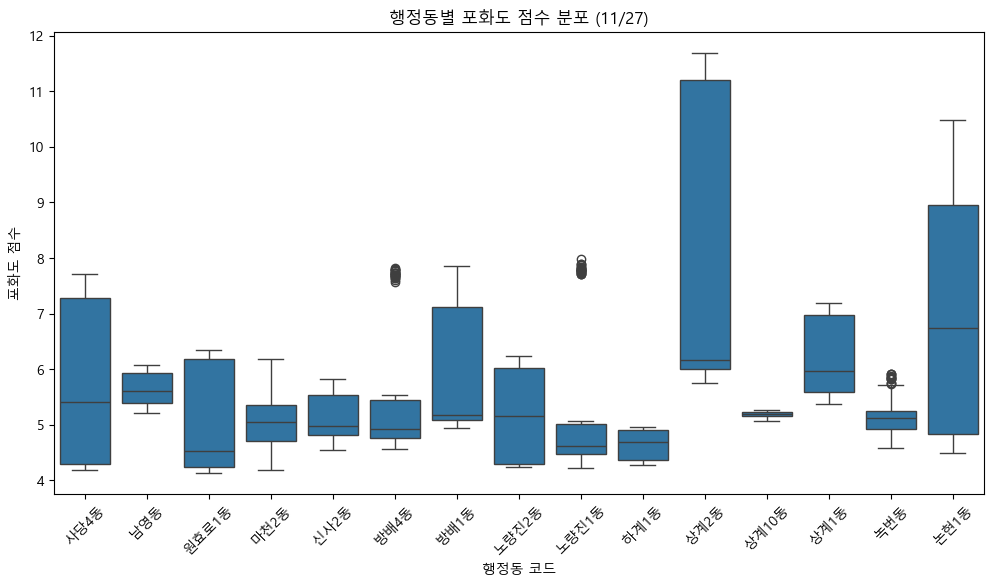

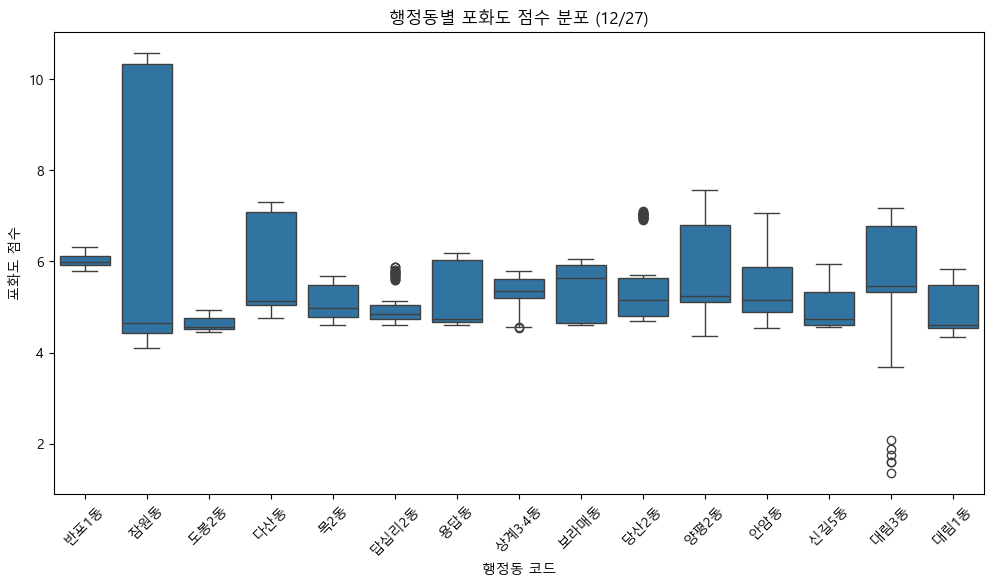

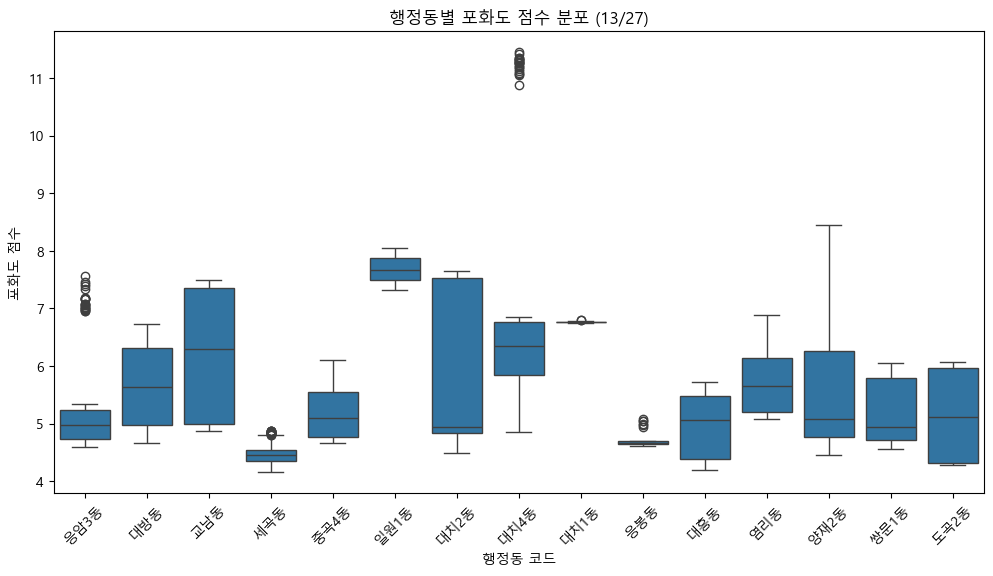

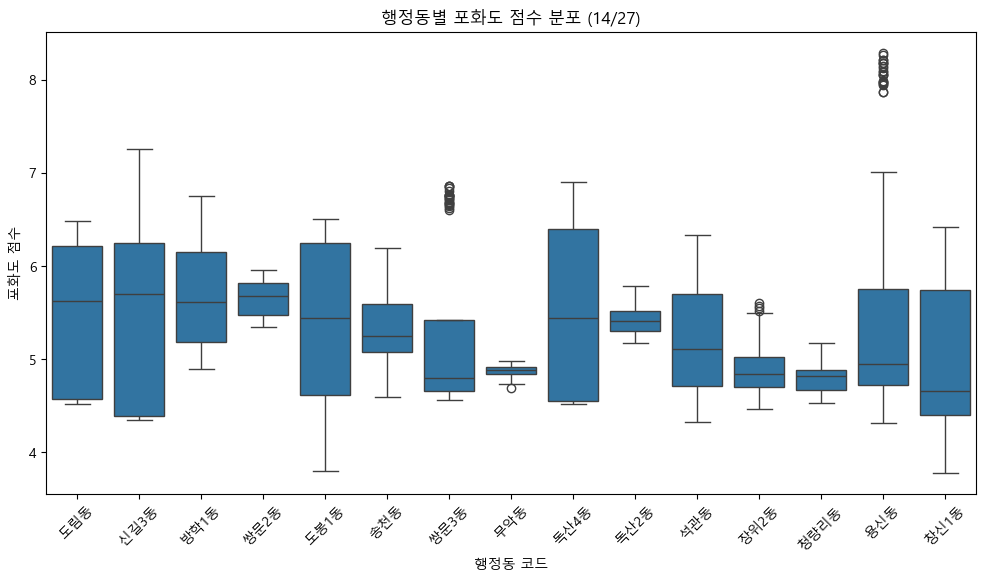

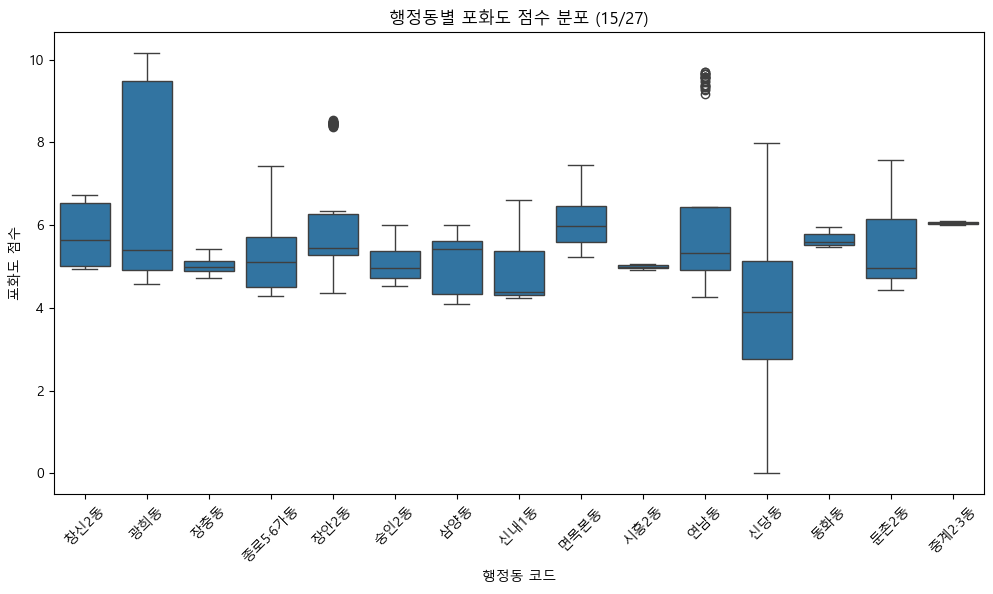

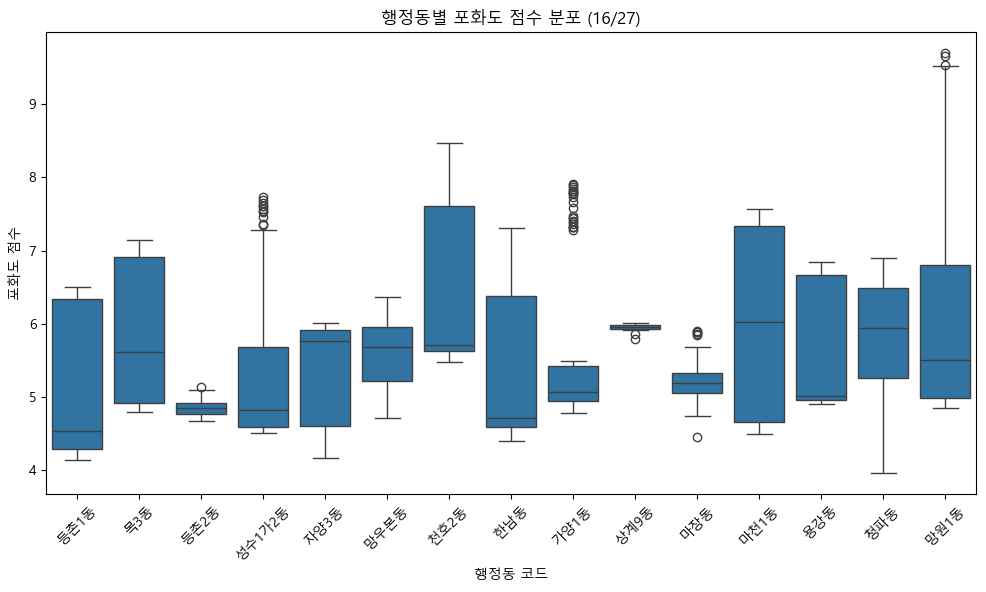

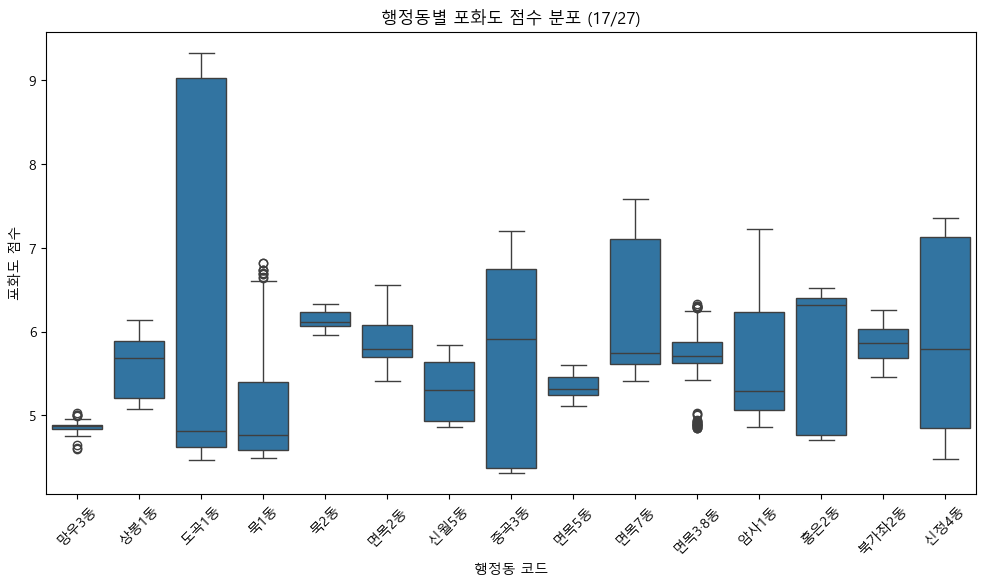

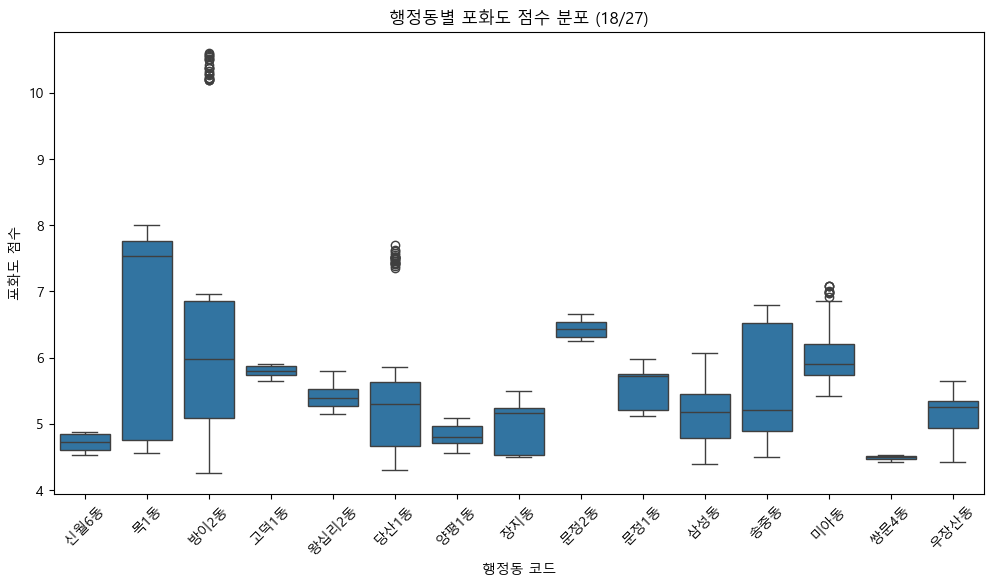

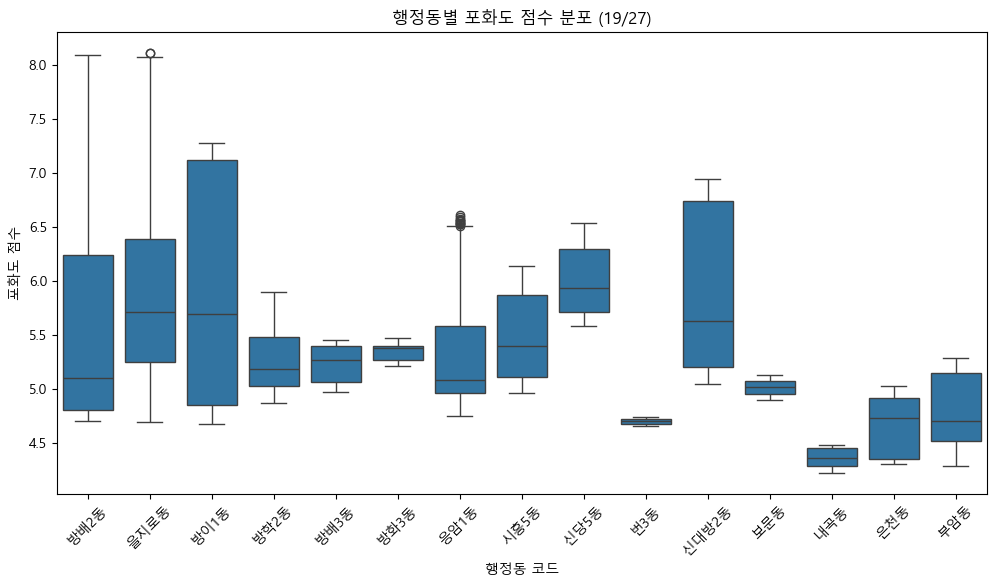

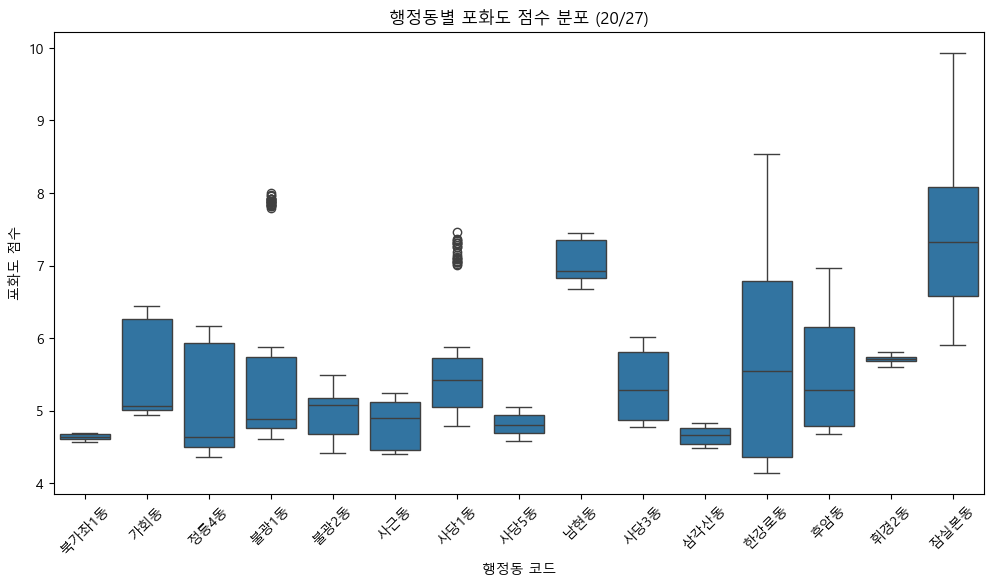

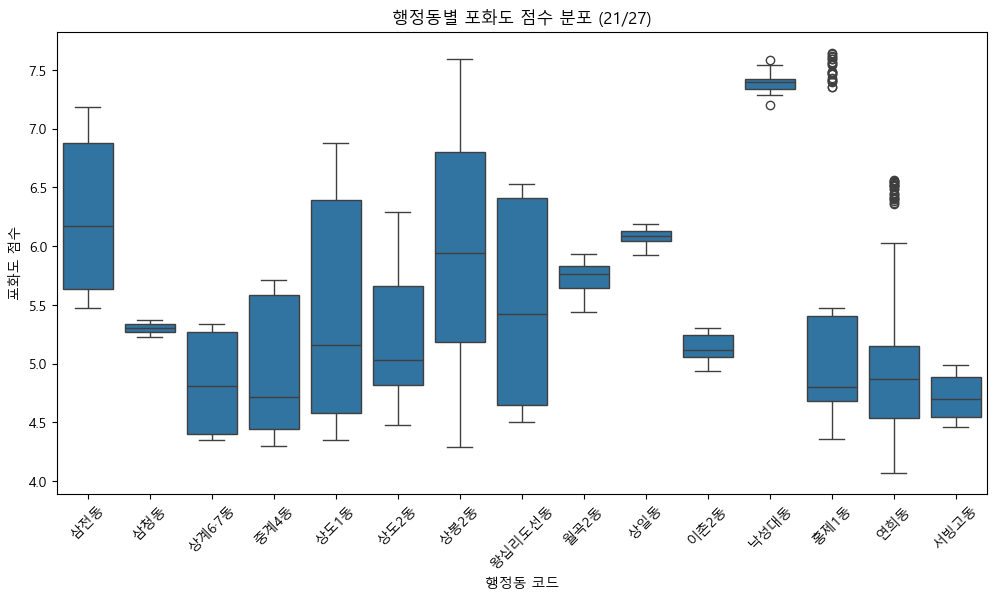

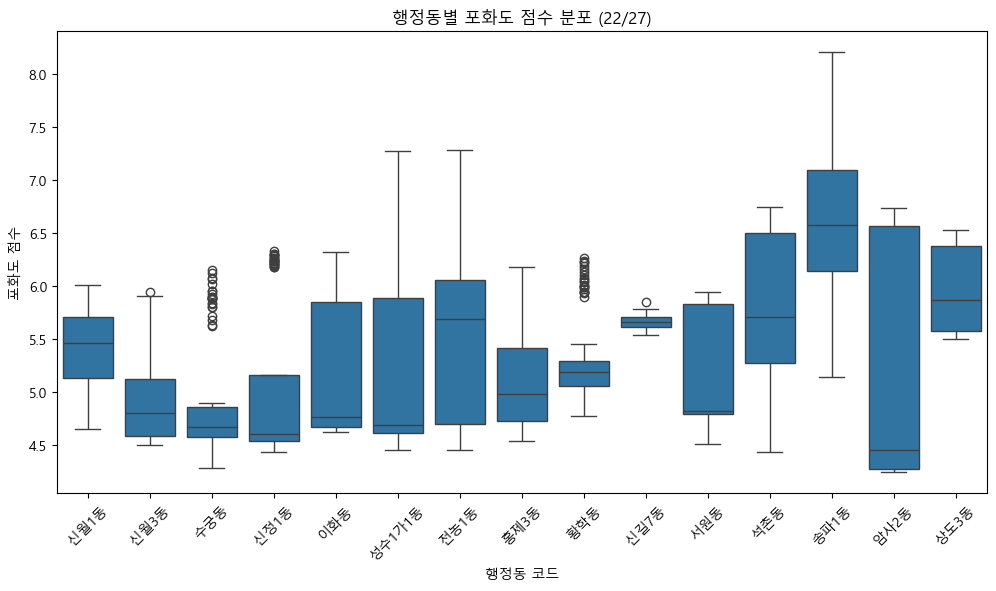

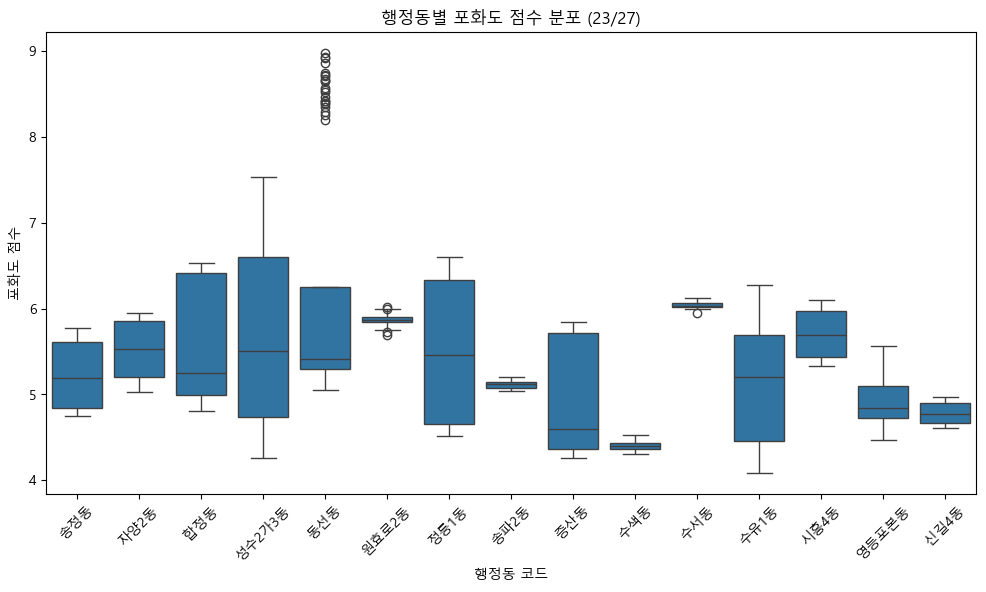

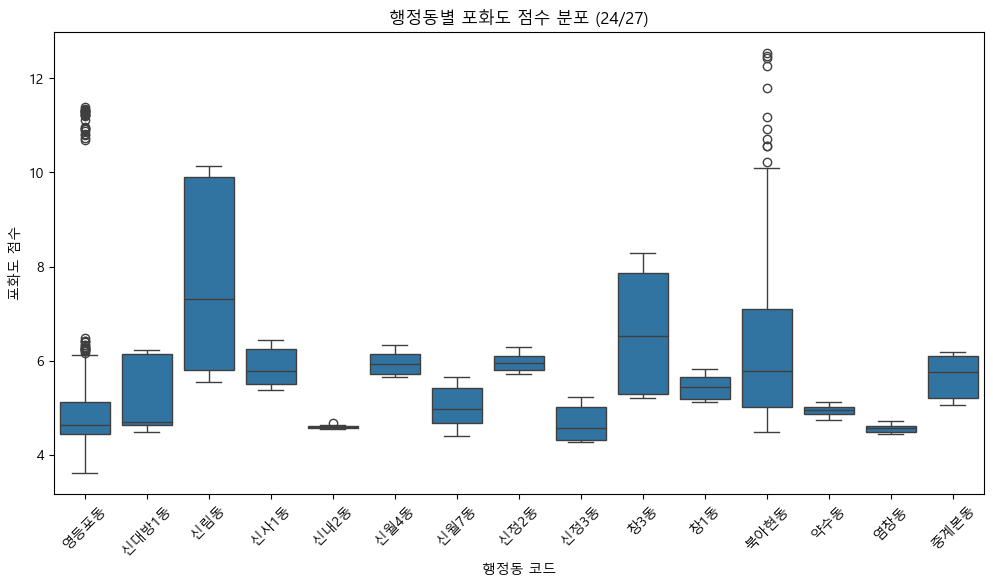

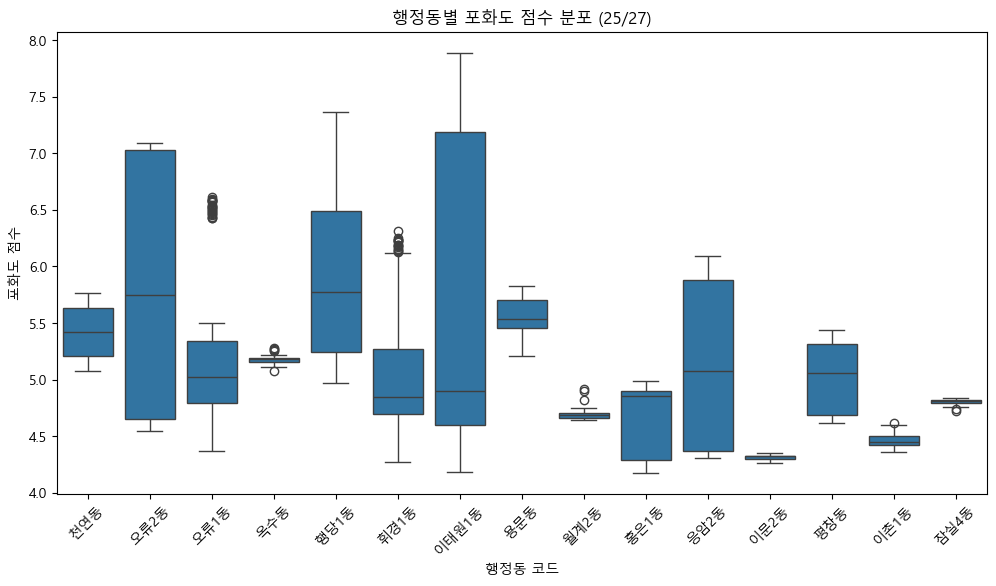

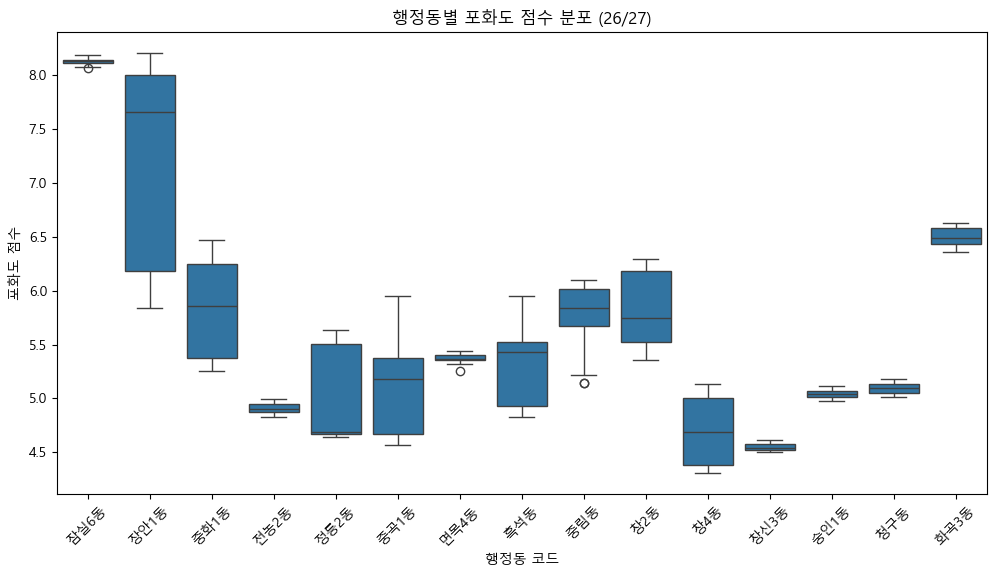

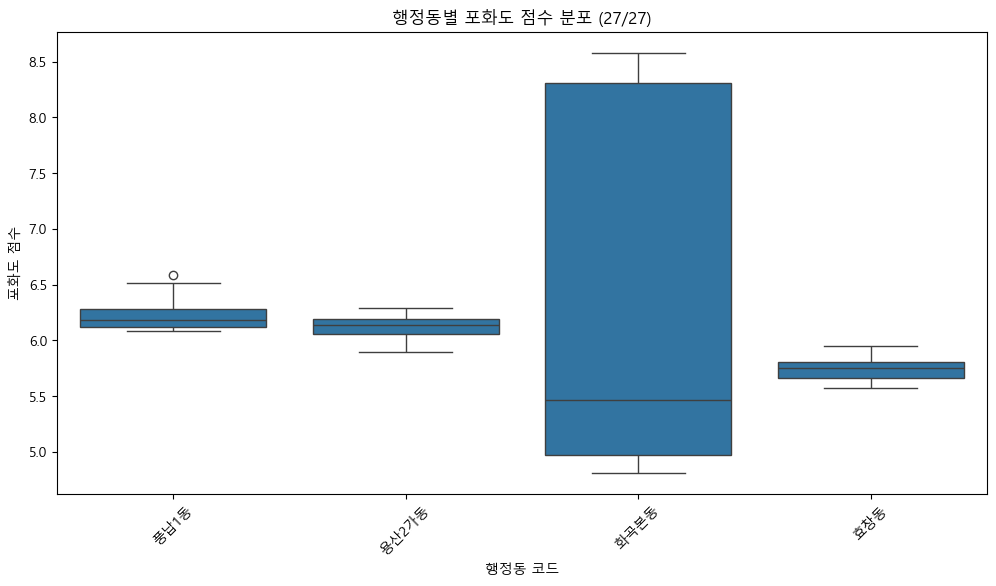

In [597]:
# 고유한 행정동 코드 목록 가져오기
unique_dong_codes = merged_df['행정동_코드_명'].unique()
num_dongs = len(unique_dong_codes)

# 한 번에 표시할 개수
chunk_size = 15

# 총 몇 개의 그래프가 필요한지 계산
num_plots = int(np.ceil(num_dongs / chunk_size))

for i in range(num_plots):
    plt.figure(figsize=(12, 6))  # 그래프 크기 설정

    # 현재 그룹에 포함될 행정동 코드 선택
    chunk = unique_dong_codes[i * chunk_size: (i + 1) * chunk_size]

    # 필터링하여 박스 플롯 생성
    sns.boxplot(data=merged_df[merged_df['행정동_코드_명'].isin(chunk)], 
                x='행정동_코드_명', y='포화도_점수')

    plt.xticks(rotation=45)  # X축 라벨 회전 (가독성 향상)
    plt.xlabel('행정동 코드')  
    plt.ylabel('포화도 점수')
    plt.title(f'행정동별 포화도 점수 분포 ({i+1}/{num_plots})')

    plt.show()  # 그래프 출력


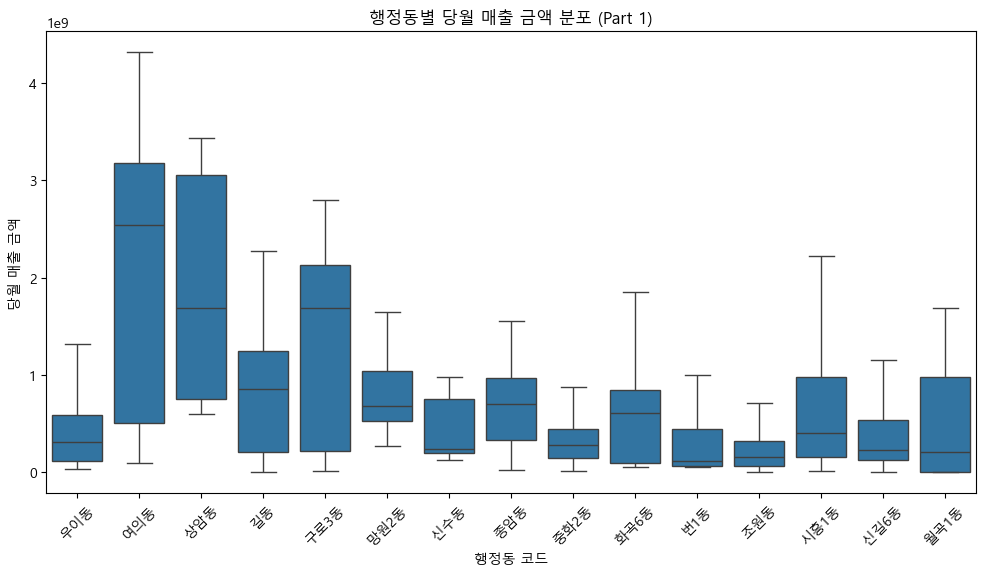

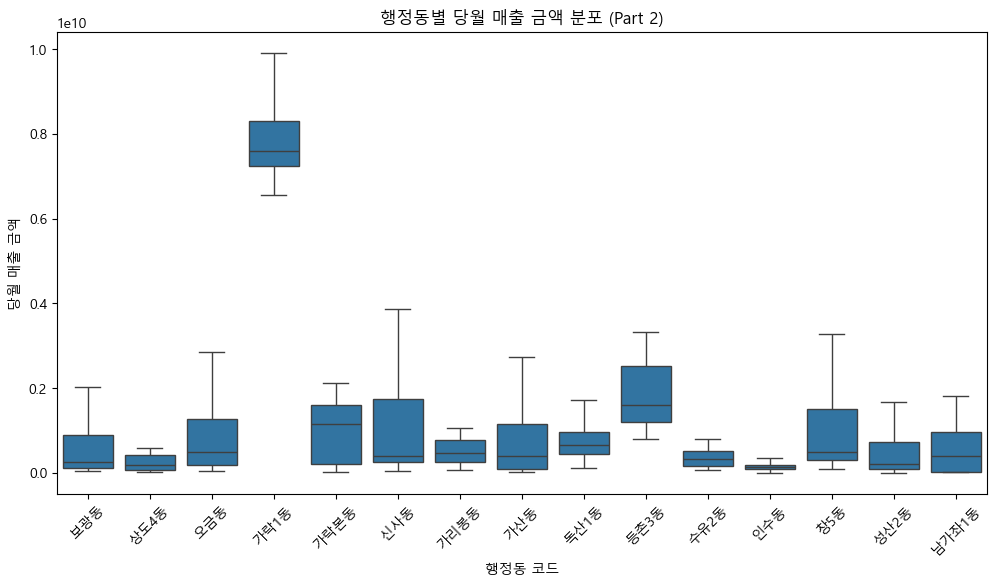

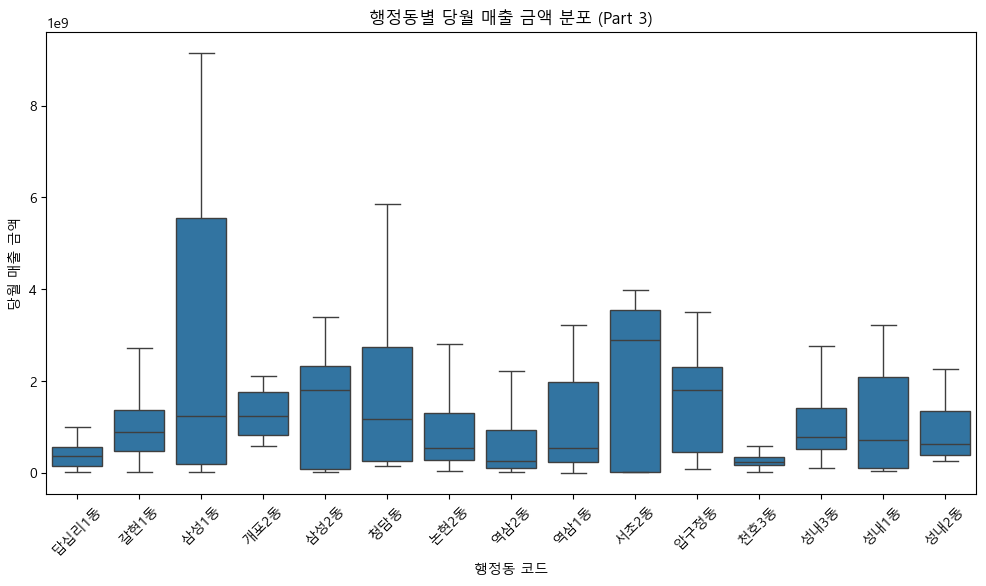

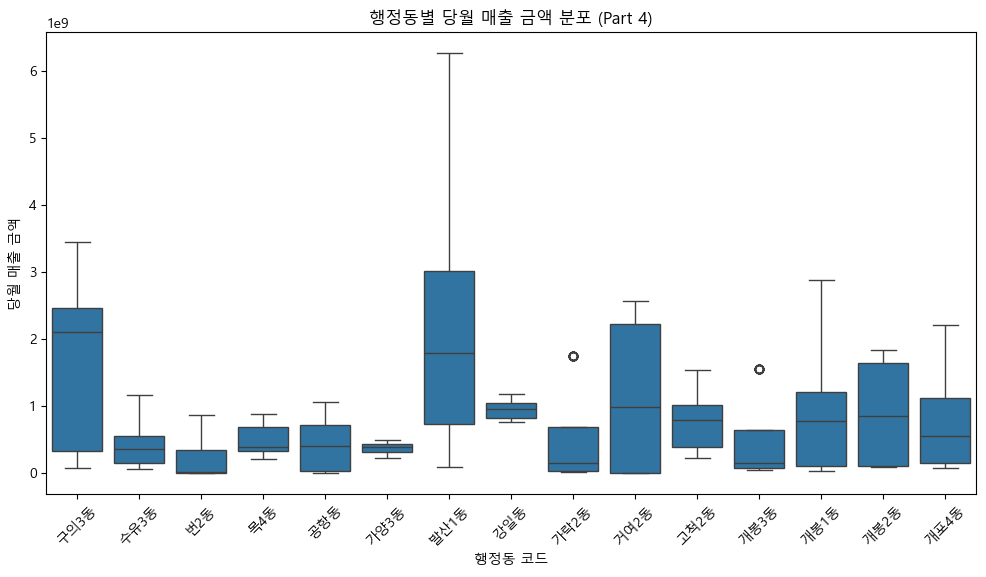

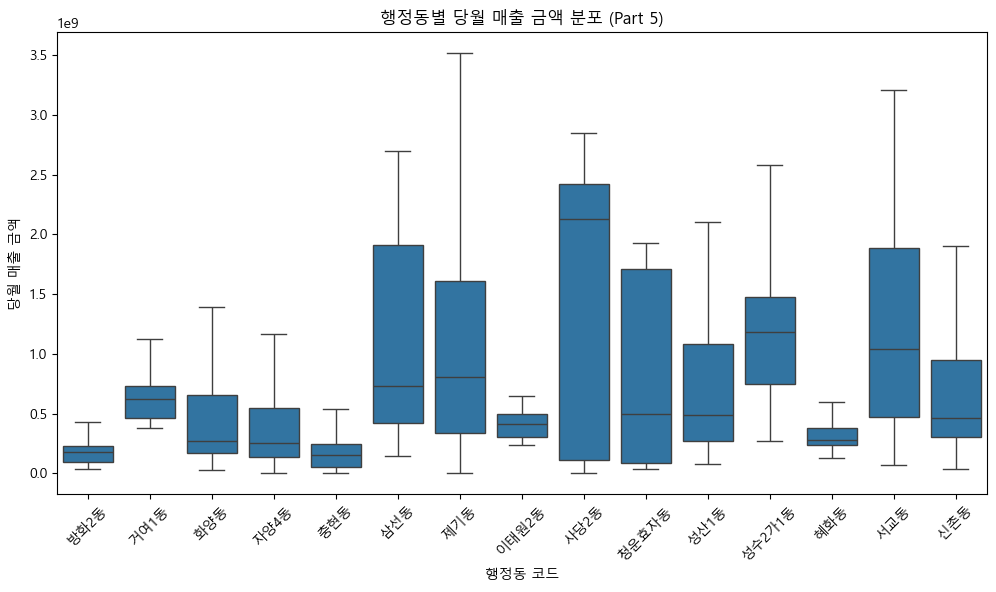

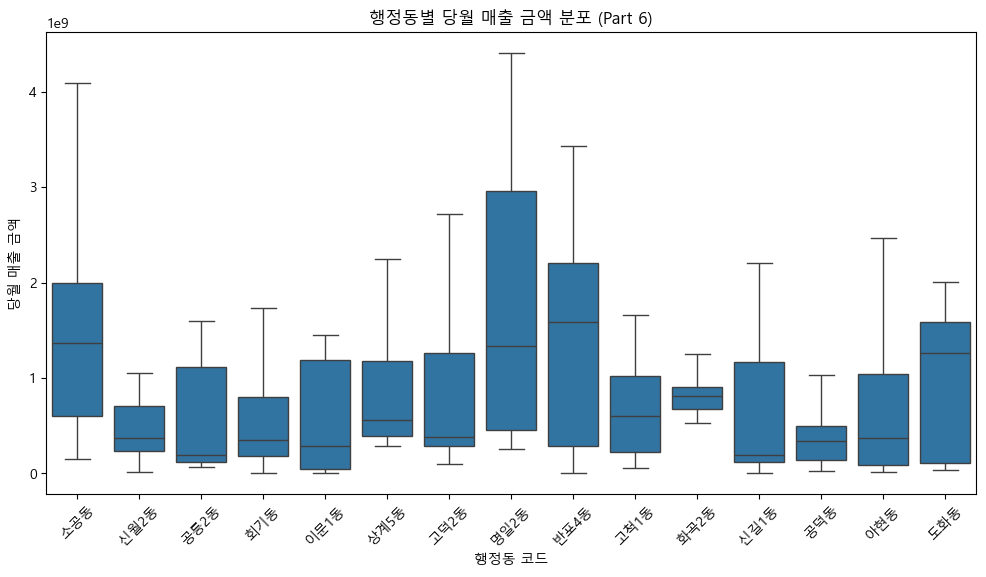

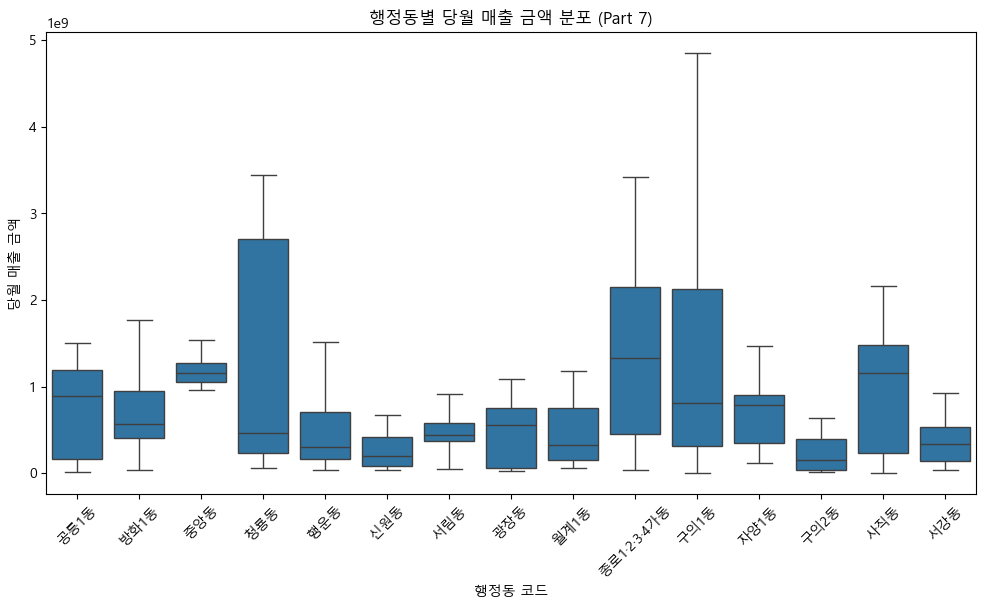

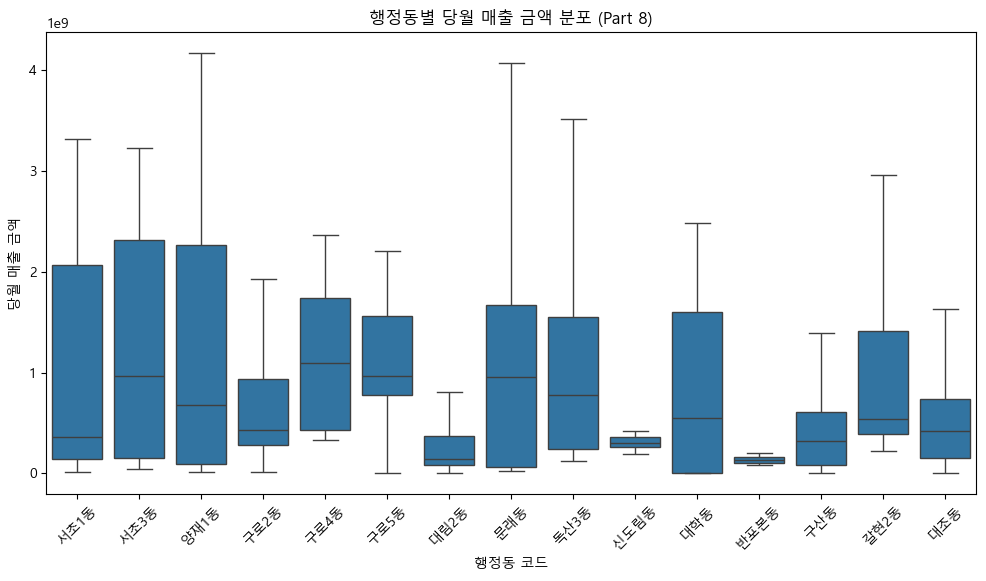

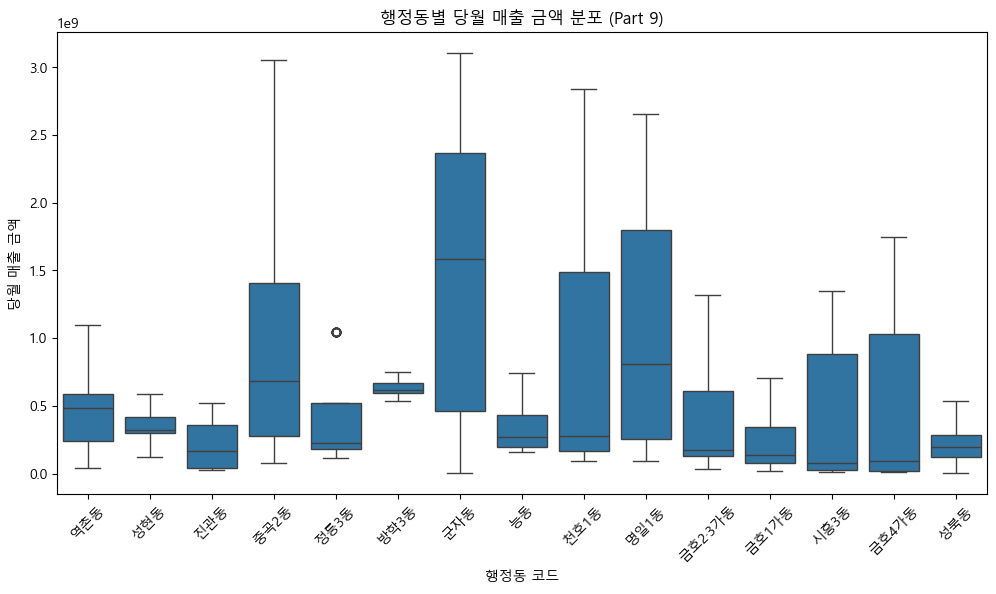

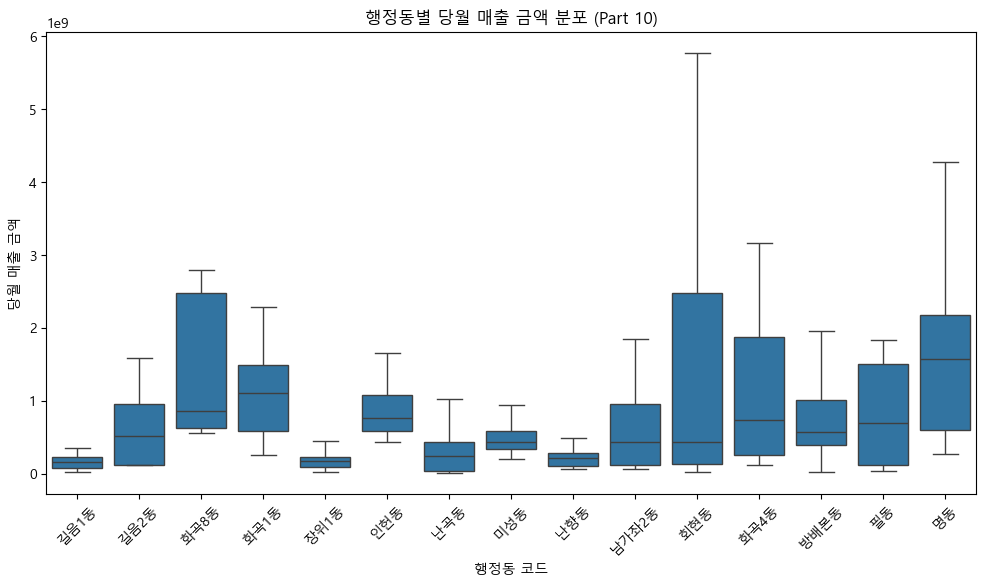

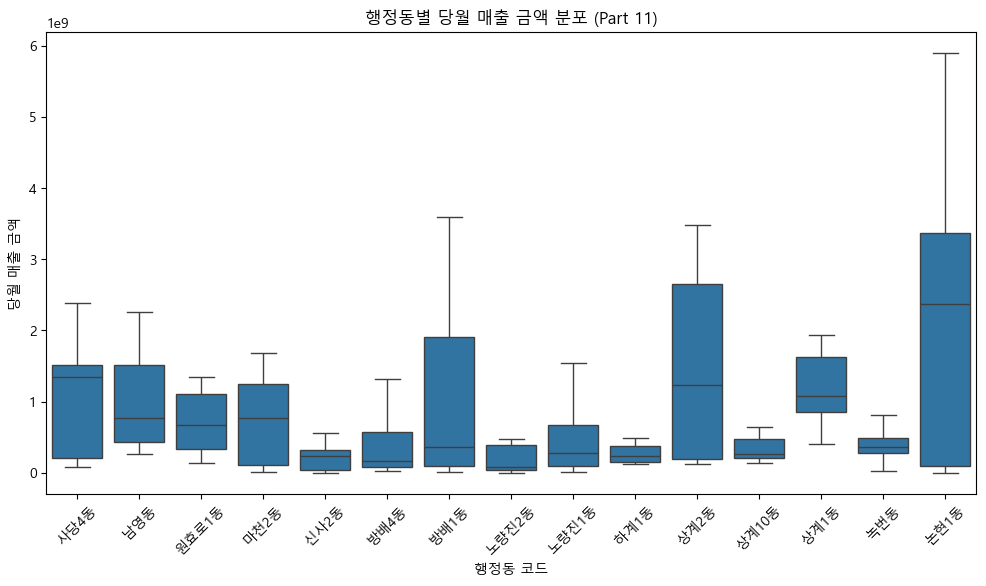

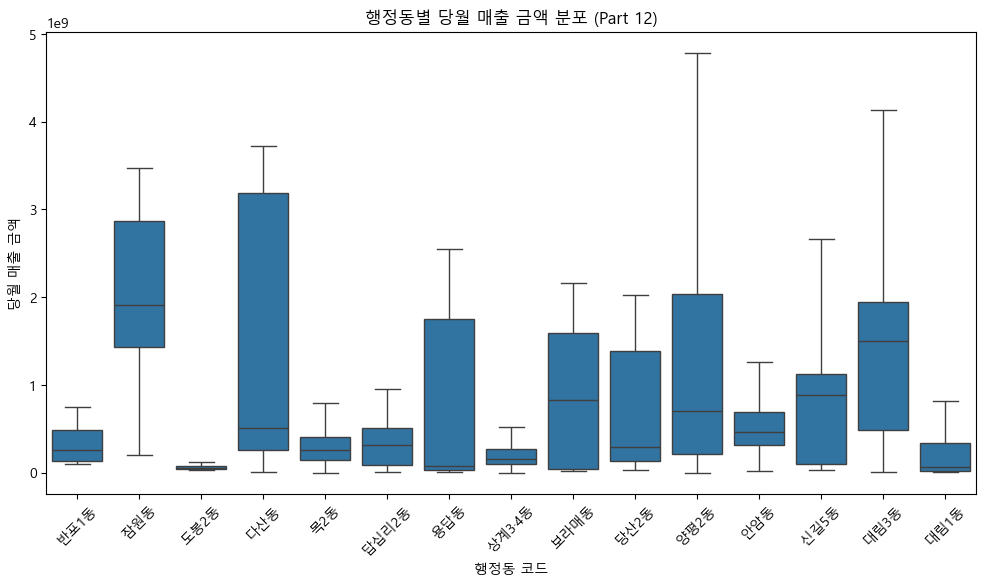

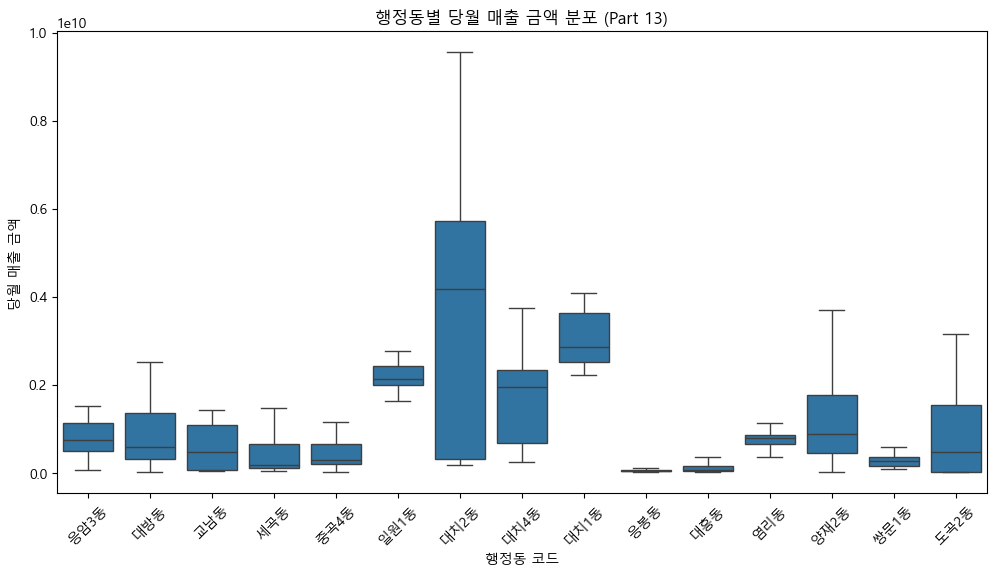

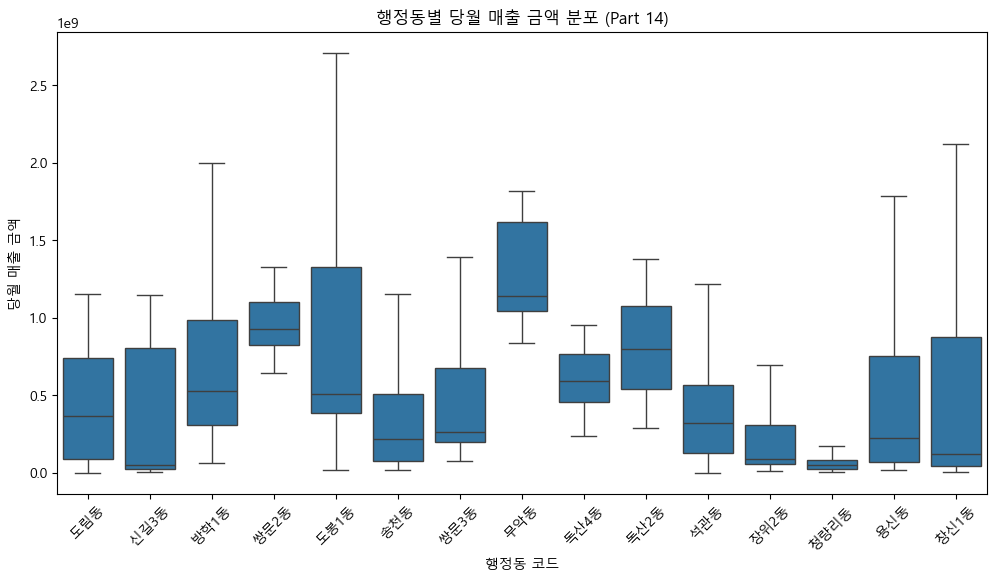

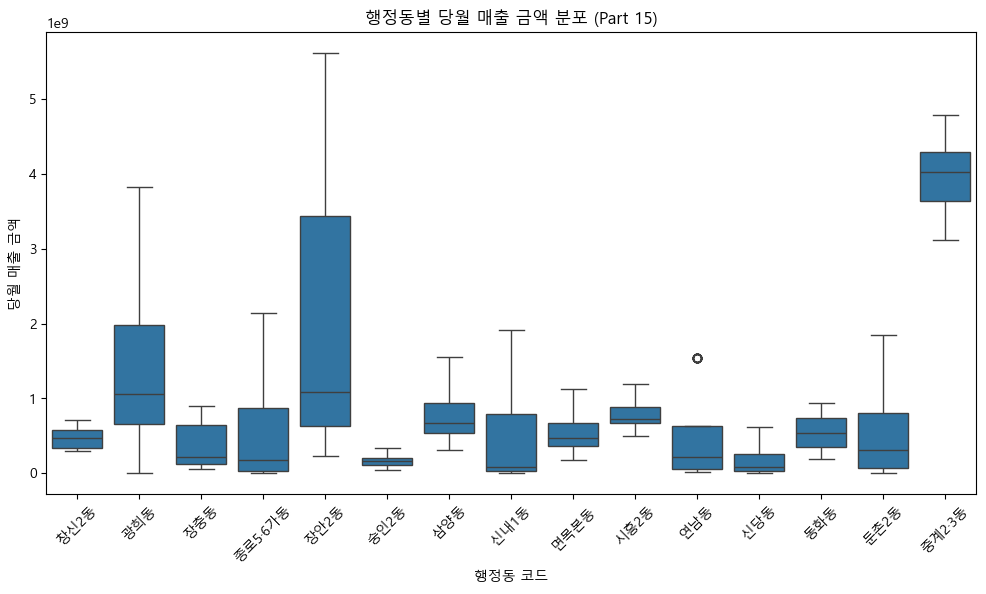

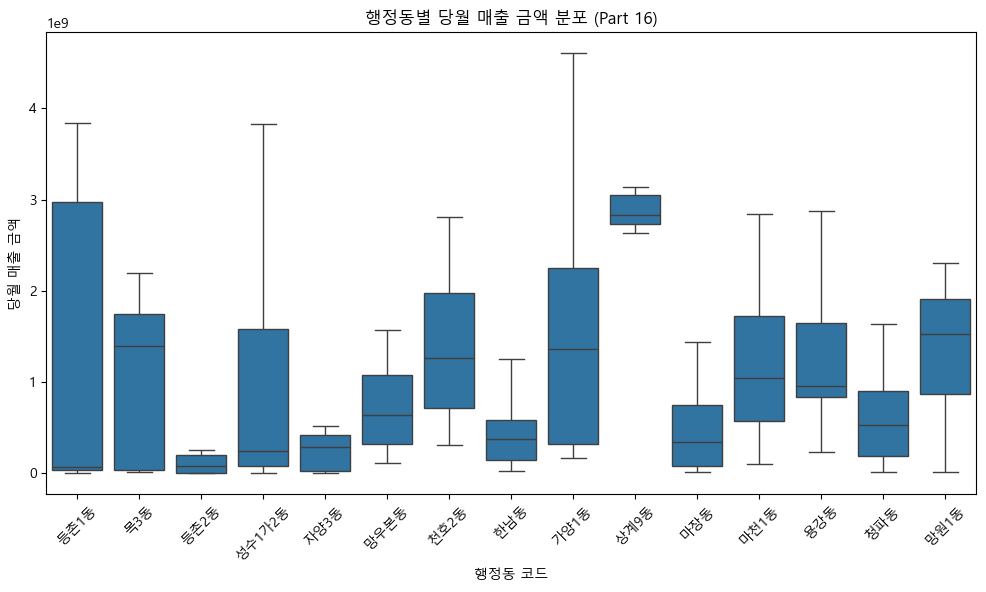

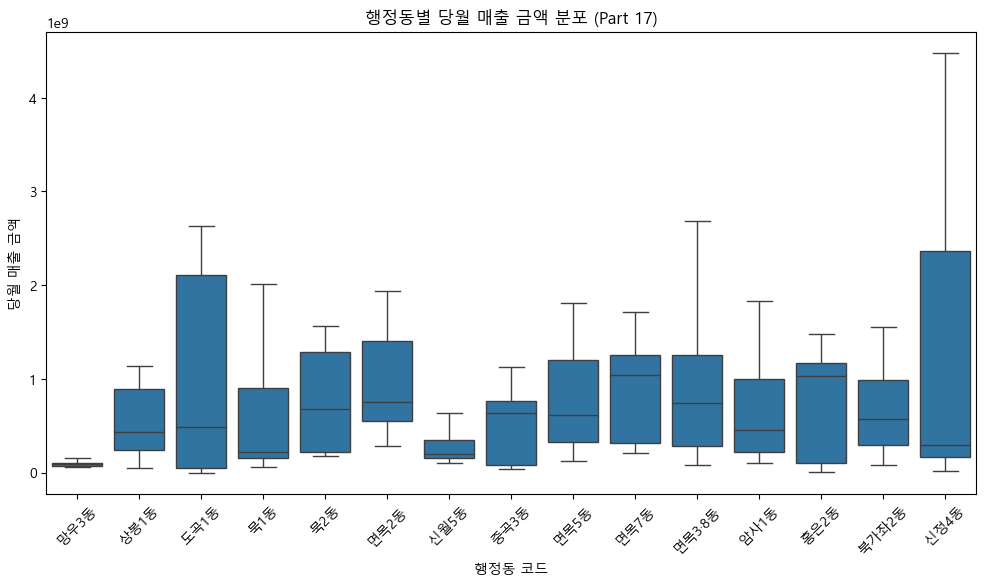

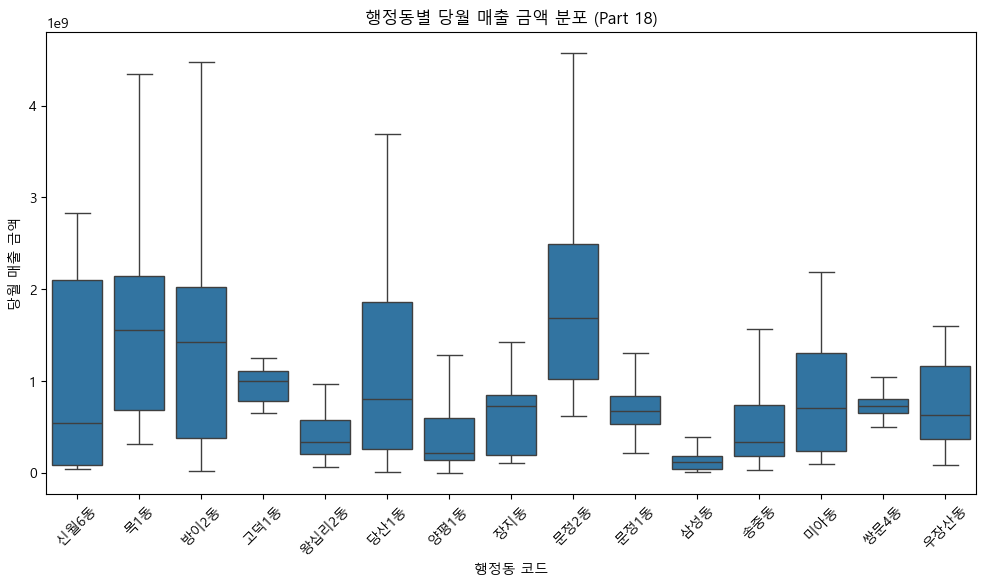

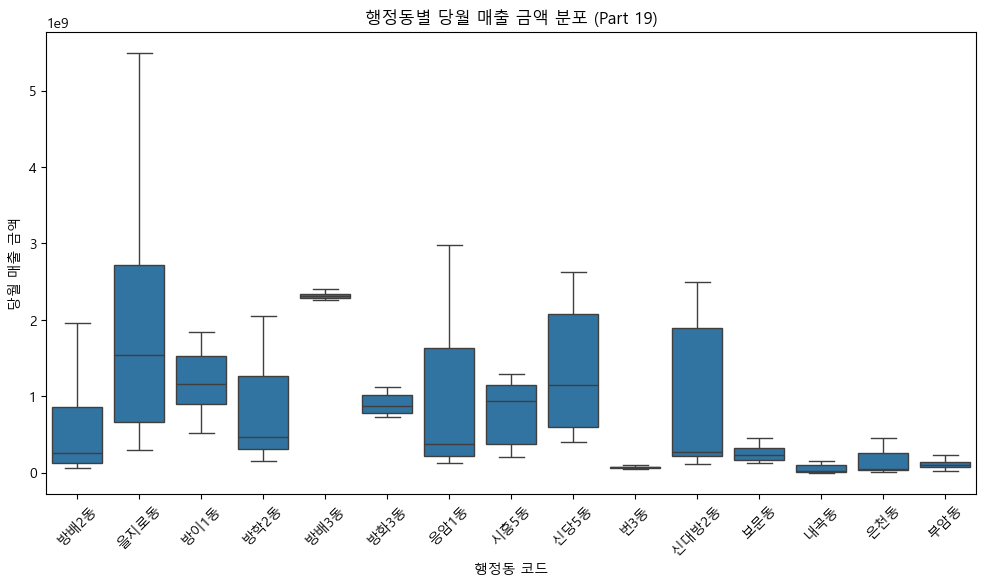

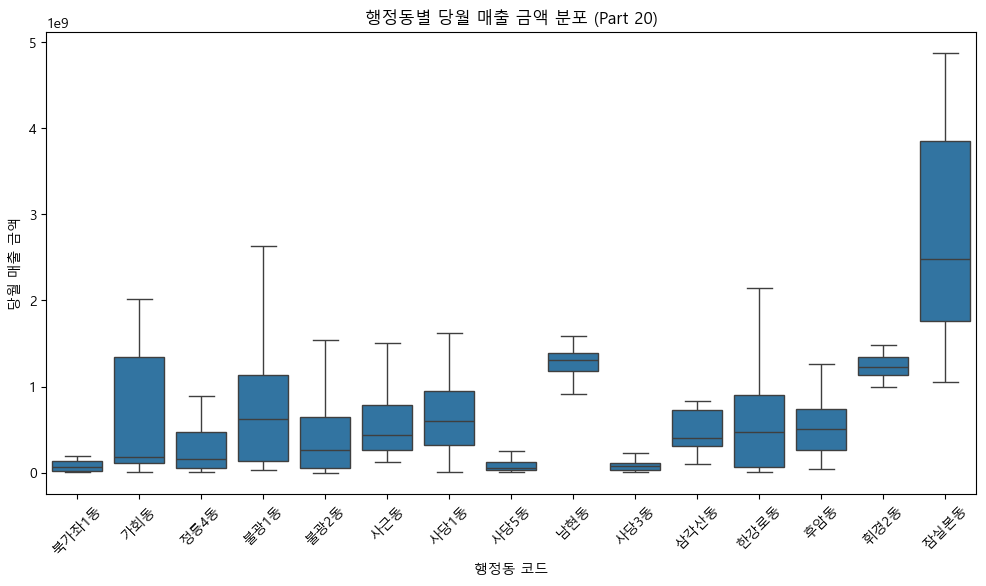

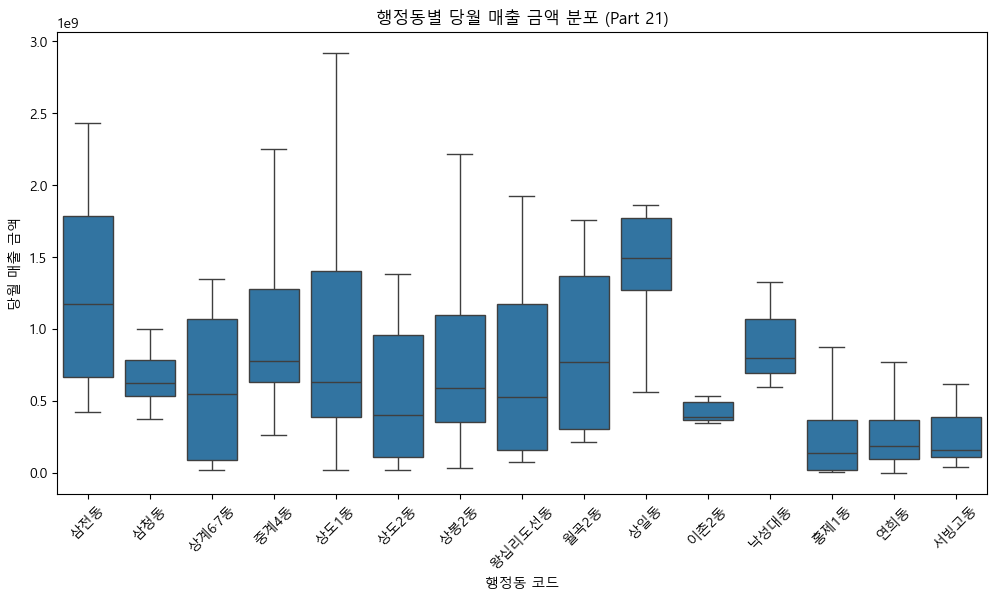

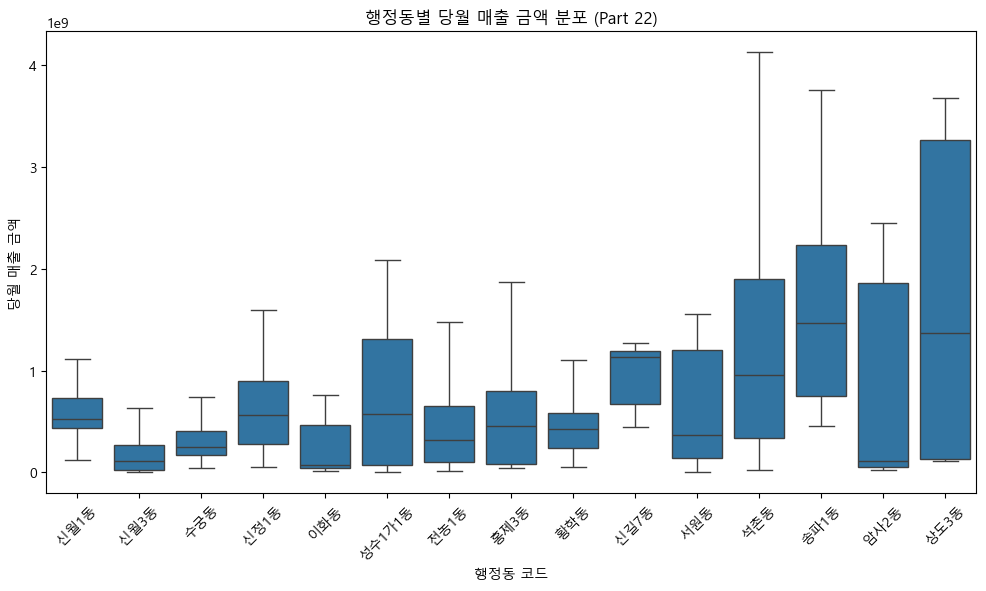

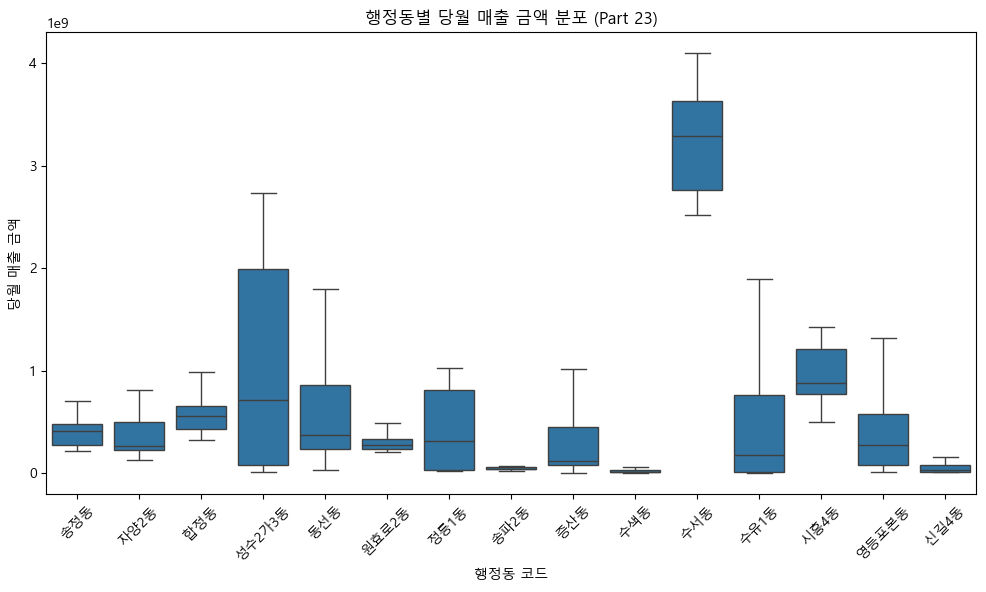

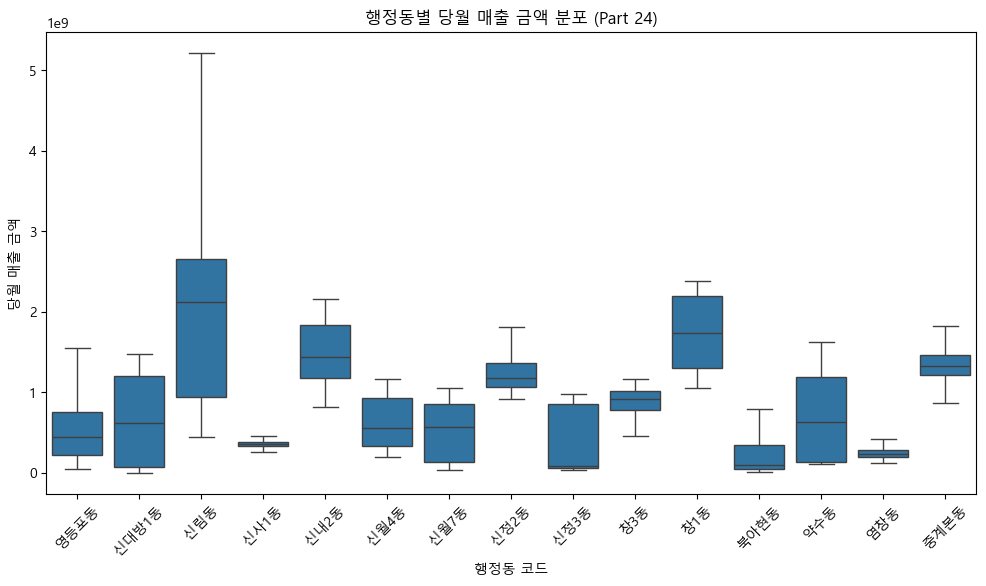

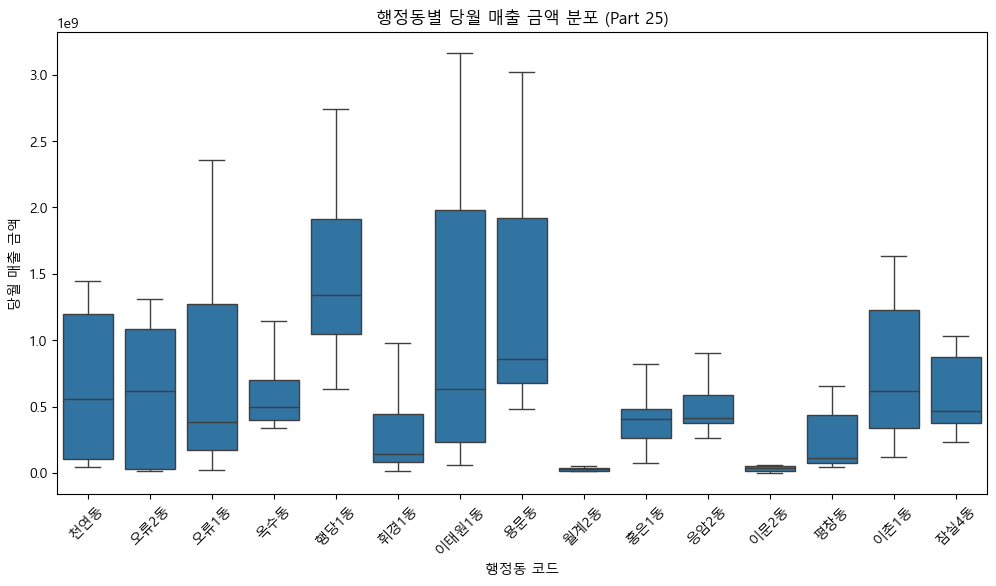

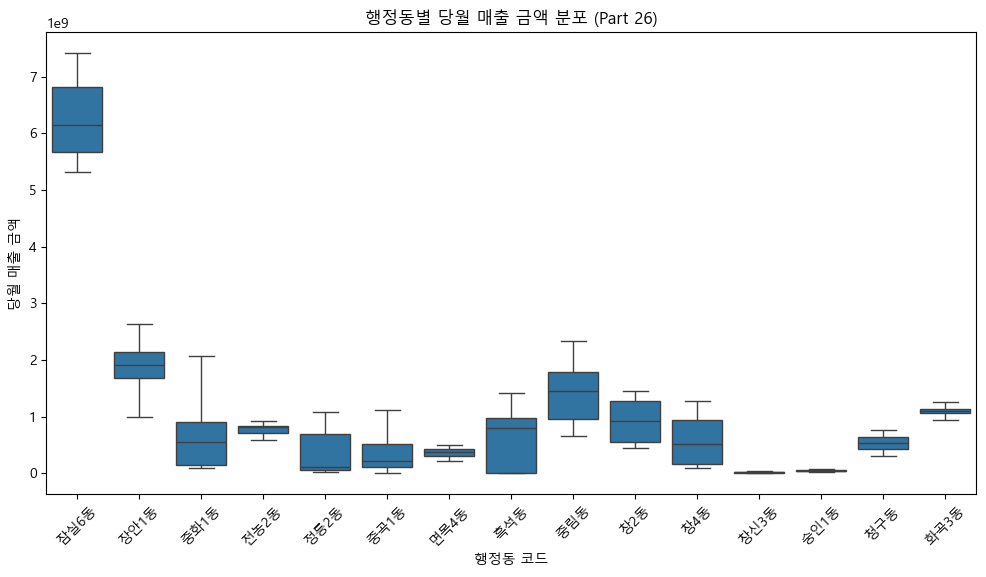

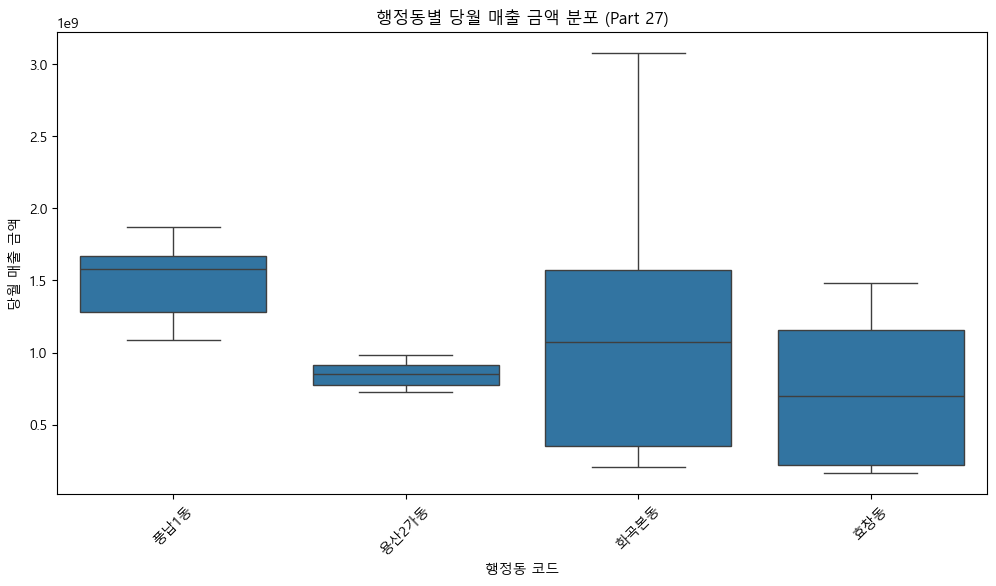

In [583]:
# # 행정동 목록 가져오기
# unique_dongs = df_corrected["행정동_코드_명"].unique()
# num_dongs = len(unique_dongs)

# # 15개씩 나누기
# dong_chunks = [unique_dongs[i:i+15] for i in range(0, num_dongs, 15)]

# # 그래프 그리기
# for i, dong_list in enumerate(dong_chunks):
#     plt.figure(figsize=(12, 6))
#     sns.boxplot(x="행정동_코드_명", y="당월_매출_금액", data=df_corrected[df_corrected["행정동_코드_명"].isin(dong_list)])

#     plt.xticks(rotation=45)  # x축 글자 회전
#     plt.xlabel("행정동 코드")
#     plt.ylabel("당월 매출 금액")
#     plt.title(f"행정동별 당월 매출 금액 분포 (Part {i+1})")
    
#     plt.show()
